# Proyecto
### EL4106 Inteligencia Computacional

Integrantes Grupo 12b:<br>
* Nicolás Becerra
* Ricardo Espinoza

Profesor: Pablo Estevez<br>
Profesor auxiliar: Juan Urrutia<br>
Ayudante: Francisca Cona

## Base

In [1]:
import os
import sys
import time

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, add
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
from torchmetrics.functional import dice_score

### Carga de Datos

In [2]:
train_annot = np.load("train_annot.npy")
train_imgs = np.load("train_imgs.npy")
val_annot = np.load("val_annot.npy")
val_imgs = np.load("val_imgs.npy")
test_annot = np.load("test_annot.npy")
test_imgs = np.load("test_imgs.npy")

datasets = [train_annot, train_imgs, val_annot, val_imgs, test_annot, test_imgs]
datasets_annot = [train_annot, val_annot, test_annot]
datasets_str = ["train_annot", "train_imgs", "val_annot", "val_imgs", "test_annot", "test_imgs"]

## EDA

Se revisan las dimensiones de los datasets.

In [3]:
for i in range(len(datasets_str)):
  print(datasets_str[i], ": ", datasets[i].shape)

train_annot :  (4564, 256, 256)
train_imgs :  (4564, 256, 256)
val_annot :  (502, 256, 256)
val_imgs :  (502, 256, 256)
test_annot :  (1240, 256, 256)
test_imgs :  (1240, 256, 256)


Se confirma que los datasets terminados en "annot" contengan las etiquetas esperadas: [0, 1, 2]

In [4]:
print(np.unique(train_annot))
print(np.unique(val_annot))
print(np.unique(test_annot))

[0 1 2]
[0 1 2]
[0 1 2]


Se revisa una de las imágenes del dataset de training.

In [5]:
print(train_imgs[0].shape)

(256, 256)


In [6]:
print(train_annot[0].shape)

(256, 256)


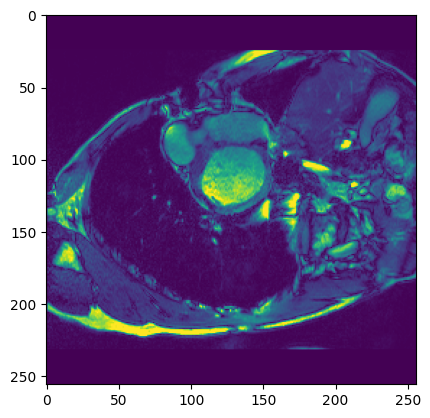

In [7]:
plt.imshow(train_imgs[0])

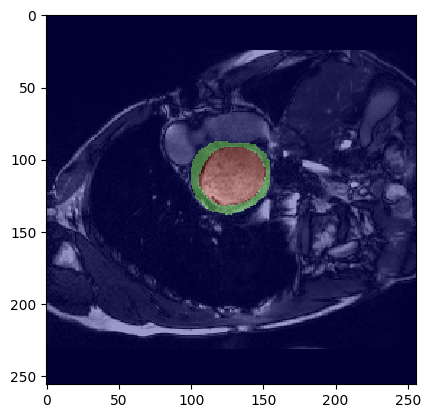

In [8]:
plt.imshow(train_imgs[0], cmap = "gray", interpolation = "none")
plt.imshow(train_annot[0], cmap = "jet", interpolation = "none", alpha=0.4)

Se transforman todos los 2 (que representan la cavidad ventricular derecha, roja en la imagen anterior) por 0's (fondo).

In [9]:
train_annot[train_annot > 1] = 0
val_annot[val_annot > 1] = 0
test_annot[test_annot > 1] = 0

Se observa el cambio. Ahora mostrando segmentación binaria del miocardio.

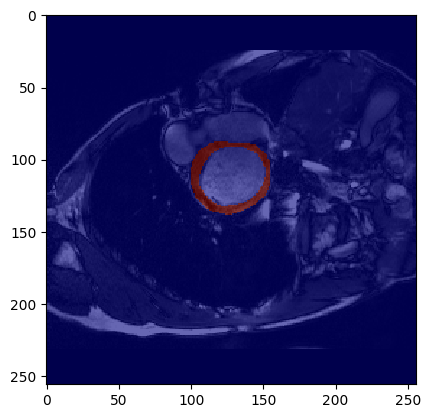

In [10]:
plt.imshow(train_imgs[0], cmap = "gray", interpolation = "none")
plt.imshow(train_annot[0], cmap = "jet", interpolation = "none", alpha=0.6)

Se transforman los datasets a tensores.

In [11]:
#Pasar a tensor desde numpy:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_imgs), torch.from_numpy(train_annot))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_imgs), torch.from_numpy(val_annot))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_imgs), torch.from_numpy(test_annot))

## Encoder - Decoder

In [12]:
class UNet(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
           
            # Bloque 1
            nn.Conv2d(1, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 4
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 256),
            nn.ReLU(),

            # Bloque 5
            nn.ConvTranspose2d(256, 256, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),

            # Bloque 6
            nn.ConvTranspose2d(128, 128, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            
            # Bloque 7
            nn.ConvTranspose2d(64, 64, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 32),
            nn.ReLU(),

            # Bloque 7
            nn.Conv2d(32, 1, kernel_size=1, padding="same"),
            nn.Sigmoid()
        )

    def forward(self, x):
      return self.conv_blocks(x)

In [13]:
#UNetSkip
class UNetSkip(nn.Module):
    skip_connections = []
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
    
        self.conv_blocks = nn.Sequential(
            
            # Bloque 1 (0-2)
            nn.Conv2d(1, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            #Bloque (3-5)
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            #Flecha (6)
            nn.MaxPool2d(kernel_size=2),
            
            # Bloque 2 (7-9)
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            #Bloque (10-12)
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            #Flecha (13)
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3 (14-16)
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            #Bloque (17-19)
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            #Flecha (20)
            nn.MaxPool2d(kernel_size=2),

            # Bloque 4 (21-23)
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 256),
            nn.ReLU(),
            #Bloque (24-26)
            nn.Conv2d(256, 256, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 256),
            nn.ReLU(),

            #Flecha naranja (27-29)
            nn.ConvTranspose2d(256, 256, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.GroupNorm(8, 256),
            nn.ReLU(),

            # Bloque 5 (30-32)
            nn.Conv2d(256, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 256),
            nn.ReLU(),
            # Bloque (33-35)
            nn.Conv2d(256, 128, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),

            #Flecha naranja (36-38)
            nn.ConvTranspose2d(128, 128, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.GroupNorm(8, 128),
            nn.ReLU(),

            #Bloque 6 (39-41)
            nn.Conv2d(128, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            #Bloque (42-44)
            nn.Conv2d(128, 64, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            
            # Flecha naranja (45-47)
            nn.ConvTranspose2d(64, 64, kernel_size=2, padding=0, dilation=1, stride=2),
            nn.GroupNorm(8, 64),
            nn.ReLU(),

            # Bloque 7 (48-50)
            nn.Conv2d(64, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            #Bloque (51-53)
            nn.Conv2d(64, 32, kernel_size=3, padding="same"),
            nn.GroupNorm(8, 32),
            nn.ReLU(),

            # Bloque 8 (54-55)
            nn.Conv2d(32, 1, kernel_size=1, padding="same"),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        for i, layer in enumerate(self.conv_blocks):
            #Indices de bajada
            if i in [5, 12, 19]:
                x = layer(x)
                self.skip_connections.append(x)
            elif i in [31, 40, 49]:
                x = torch.cat([x, self.skip_connections.pop(-1)], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    

## Model Summary

In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
model = UNetSkip(dropout_p=0)
summary(model.to(device), (1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─GroupNorm: 2-2                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─GroupNorm: 2-5                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └─GroupNorm: 2-9                    [-1, 64, 128, 128]        128
|    └─ReLU: 2-10                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-11                      [-1, 64, 128, 128]        36,928
|    └─GroupNorm: 2-12                   [-1, 64, 128, 128]        128
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─GroupNorm: 2-2                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─GroupNorm: 2-5                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └─GroupNorm: 2-9                    [-1, 64, 128, 128]        128
|    └─ReLU: 2-10                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-11                      [-1, 64, 128, 128]        36,928
|    └─GroupNorm: 2-12                   [-1, 64, 128, 128]        128
|

In [16]:
model = UNet(dropout_p=0)
summary(model.to(device), (1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256, 256]         --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─GroupNorm: 2-2                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-5                       [-1, 64, 128, 128]        18,496
|    └─GroupNorm: 2-6                    [-1, 64, 128, 128]        128
|    └─ReLU: 2-7                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-9                       [-1, 128, 64, 64]         73,856
|    └─GroupNorm: 2-10                   [-1, 128, 64, 64]         256
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256, 256]         --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─GroupNorm: 2-2                    [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-5                       [-1, 64, 128, 128]        18,496
|    └─GroupNorm: 2-6                    [-1, 64, 128, 128]        128
|    └─ReLU: 2-7                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-9                       [-1, 128, 64, 64]         73,856
|    └─GroupNorm: 2-10                   [-1, 128, 64, 64]         256
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
|   

## Funciones

In [17]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):

    # Predicción
    y_predicted = model(x_batch.float())
    # Cálculo de loss
    loss = criterion(torch.squeeze(y_predicted, 1), y_batch.float())

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu,threshold):
    cumulative_loss = 0
    cumulative_predictions = 0
    cumulative_iou = 0 #
    cumulative_dice = 0 #
    data_count = 0
    val_hist_iou =[]
    val_hist_dice =[]

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda().unsqueeze(1)
            y_val = y_val.cuda()

        y_predicted = model(x_val.float())
        
        loss = criterion(torch.squeeze(y_predicted, 1), y_val.float())

        class_prediction = (y_predicted >= threshold).long().squeeze(1) 

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

        true = y_val.cpu().detach().numpy()[0] #
        pred = (y_predicted.cpu() >= threshold).long().detach().numpy()[0][0] #

        union = true + pred #
        union[union > 1] = 1 #
        inter = true + pred - union #
        iou = np.sum(inter)/np.sum(union) #
        cumulative_iou += iou #

        dice = 2*np.sum(inter)/(np.sum(true) + np.sum(pred)) #
        cumulative_dice += dice #

        val_hist_iou.append(iou)
        val_hist_dice.append(dice)


    val_acc = cumulative_predictions/(data_count*256*256)
    val_loss = cumulative_loss / len(val_loader) 
    val_iou = cumulative_iou / len(val_loader) #
    val_dice = cumulative_dice / len(val_loader) #

    return val_acc, val_loss, val_iou, val_dice, val_hist_iou, val_hist_dice #


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    threshold=0.5,
    criteria = 'iou',
    patience = 5,
):

    if use_gpu:
        model.cuda()
    print(len(val_dataset))
    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": [],
        "hist_train_iou": [],
        "hist_val_iou":[],
        "train_dice": [],
        "val_dice": [],
        "hist_train_dice": [],
        "hist_val_dice":[],
       }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    patience = 0
    best = 0
    better = False

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0
        cumulative_train_iou = 0 #
        train_iou_count = 0 #
        cumulative_train_dice = 0 #
        train_dice_count = 0 #

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda().unsqueeze(1)
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch.float(), y_batch.float(), model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]
            train_iou_count += 1 #
            train_dice_count += 1 #
            class_prediction = (y_predicted >= threshold).long().squeeze(1)  
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            true = y_batch.cpu().detach().numpy()[0] #
            pred = (y_predicted.cpu() >= threshold).long().detach().numpy()[0][0] #

            union = true + pred #
            union[union > 1] = 1 #
            inter = true + pred - union #
            iou = np.sum(inter)/np.sum(union) #

            curves["hist_train_iou"].append(iou) #
        

            cumulative_train_iou += iou #
            dice = 2*np.sum(inter)/(np.sum(true) + np.sum(pred)) #
            cumulative_train_dice += dice #
            curves["hist_train_dice"].append(dice) #

            if i%10 == 0 and (i>0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / (train_acc_count*256*256)
                train_iou = cumulative_train_iou / train_iou_count #
                train_dice = cumulative_train_dice / train_dice_count #

                print(f"Epoch {epoch+1} - Iteration {iteration} - Batch {i}/{len(train_loader)}")
                print(f"Train loss: \t {train_loss} \nTrain acc:\t {train_acc}")
                print(f"Train IoU:\t {train_iou}")
                print(f"Train Dice:\t {train_dice}")

           
            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss, val_iou, val_dice, val_hist_iou, val_hist_dice  = evaluate(val_loader, model, criterion, use_gpu, threshold) #
            # Early stopping using IoU with patience of 5 epochs
            if epoch == 0:
                best_val_iou = val_iou
                best_val_dice = val_dice
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_epoch = epoch + 1
            if criteria == 'loss':
                best = best_val_loss > val_loss
            if criteria == 'acc':
                best = best_val_acc < val_acc
            if criteria == 'iou':
                best = best_val_iou < val_iou
            if criteria == 'dice':
                best = best_val_dice < val_dice
            elif best :
                best_val_iou = val_iou
                best_val_dice = val_dice
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_epoch = epoch + 1
                patience = 0
            else:
                patience += 1
                if patience == 10:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
        
        print(f"Val loss: {val_loss}, Val acc: {val_acc}, Val IoU: {val_iou}, Val Dice: {val_dice}") #

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / (train_acc_count*256*256)
        train_iou = cumulative_train_iou / train_iou_count #
        train_dice = cumulative_train_dice / train_dice_count #
        
        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        curves["train_iou"].append(train_iou) #
        curves["val_iou"].append(val_iou) #
        curves["hist_val_iou"].append(val_hist_iou) #
        curves["train_dice"].append(train_dice) #
        curves["val_dice"].append(val_dice) #
        curves["hist_val_dice"].append(val_hist_dice) #

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

In [18]:
def show_curves(curves):
    fig, ax = plt.subplots(2,3, figsize=(25,10))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0,0].plot(epochs, curves['val_loss'], label='validation')
    ax[0,0].plot(epochs, curves['train_loss'], label='training')
    ax[0,0].set_xlabel('Epoch')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_title('Loss evolution during training')
    ax[0,0].legend()

    ax[1,0].plot(epochs, curves['val_acc'], label='validation')
    ax[1,0].plot(epochs, curves['train_acc'], label='training')
    ax[1,0].set_xlabel('Epoch')
    ax[1,0].set_ylabel('Accuracy')
    ax[1,0].set_title('Accuracy evolution during training')
    ax[1,0].legend()

    ax[0,1].plot(epochs, curves['val_iou'], label='validation')
    ax[0,1].plot(epochs, curves['train_iou'], label='training')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_ylabel('IoU')
    ax[0,1].set_title('IoU evolution during training')
    ax[0,1].legend()
    
    ax[1,1].hist(curves['hist_train_iou'],20, label='training',alpha=0.6)
    ax[1,1].hist(curves['hist_val_iou'],20, label='validation')
    ax[1,1].set_xlabel('IoU')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].set_title('Histogram IoU during training')
    ax[1,1].legend()

    ax[0,2].plot(epochs, curves['val_dice'], label='validation')
    ax[0,2].plot(epochs, curves['train_dice'], label='training')
    ax[0,2].set_xlabel('Epoch')
    ax[0,2].set_ylabel('Dice')
    ax[0,2].set_title('Dice evolution during training')
    ax[0,2].legend()

    ax[1,2].hist(curves['hist_train_dice'],20, label='training',alpha=0.6)
    ax[1,2].hist(curves['hist_val_dice'],20, label='validation')
    ax[1,2].set_xlabel('Dice')
    ax[1,2].set_ylabel('Frequency')
    ax[1,2].set_title('Histogram Dice during training')
    ax[1,2].legend()    

    plt.show()

## Entrenamiento

### UNet VS UNetSkip

In [32]:
#
lr=0.01
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNet(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves0 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)


502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.16388524730097165 
Train acc:	 0.933092637495561
Train IoU:	 0.0009904878638262611
Train Dice:	 0.001959624896201786
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.11346411651798657 
Train acc:	 0.959392229715983
Train IoU:	 0.0005188269762899462
Train Dice:	 0.0010264701837247449
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.09345877579142971 
Train acc:	 0.9687910695229808
Train IoU:	 0.00035146343555125396
Train Dice:	 0.0006953507696199886
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.08253058727558066 
Train acc:	 0.9736823337834056
Train IoU:	 0.00026574064639241153
Train Dice:	 0.0005257530209321864
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.07595665993935921 
Train acc:	 0.9765920265048158
Train IoU:	 0.00021363463729586024
Train Dice:	 0.0004226641932984244
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.07124087208362877 
Train acc:	 0.9785995170718333
Train IoU:	 0.00

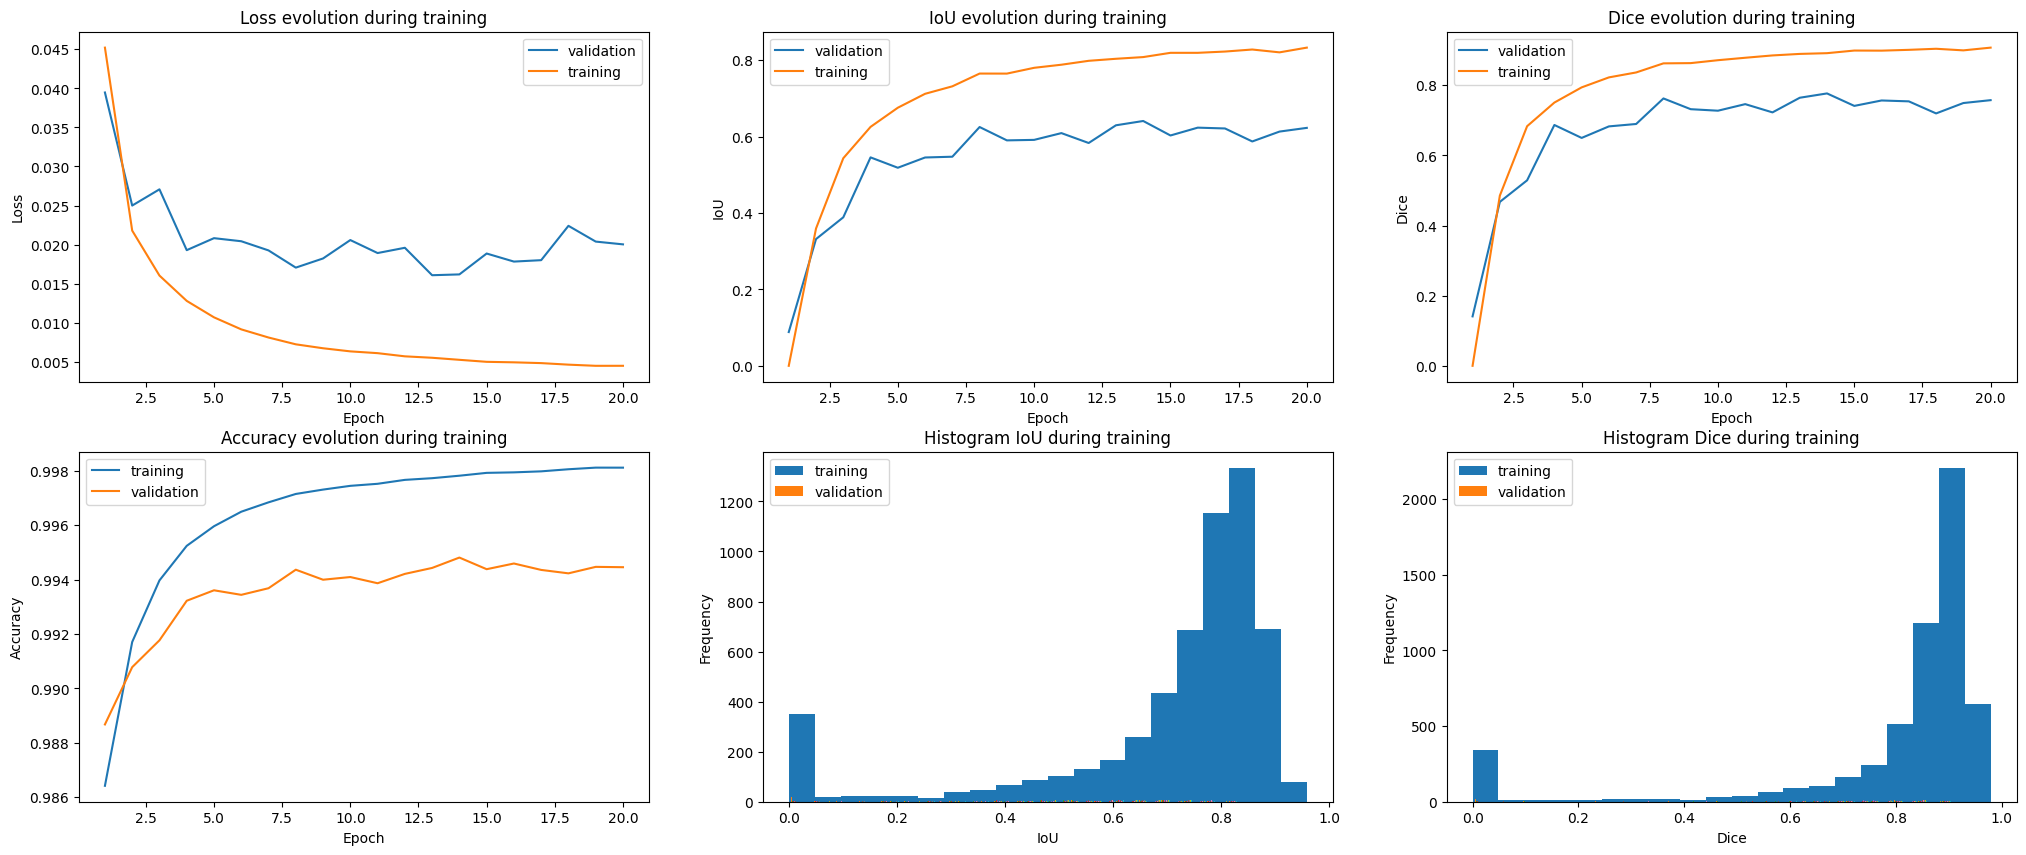

In [33]:
show_curves(curves0)

In [24]:
#Mismos parametros que el anterior pero usando el modelo UNetSkip
lr=0.01
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves0_1 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.1770775792273608 
Train acc:	 0.9736561341719194
Train IoU:	 0.004167907115212861
Train Dice:	 0.007970395673213778
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.11931052325027329 
Train acc:	 0.9810466766357422
Train IoU:	 0.002183189441301975
Train Dice:	 0.004174969162159598
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.09787694905554095 
Train acc:	 0.9835301983741022
Train IoU:	 0.0014789347828174668
Train Dice:	 0.002828204916301663
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.08637763314494272 
Train acc:	 0.9848107826418993
Train IoU:	 0.0011182189821302797
Train Dice:	 0.002138398839154916
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.07945793268142962 
Train acc:	 0.9855456071741441
Train IoU:	 0.0008989603581831661
Train Dice:	 0.0017191049491245402
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.07398121730714548 
Train acc:	 0.986259898201364
Train IoU:	 0.0007515898

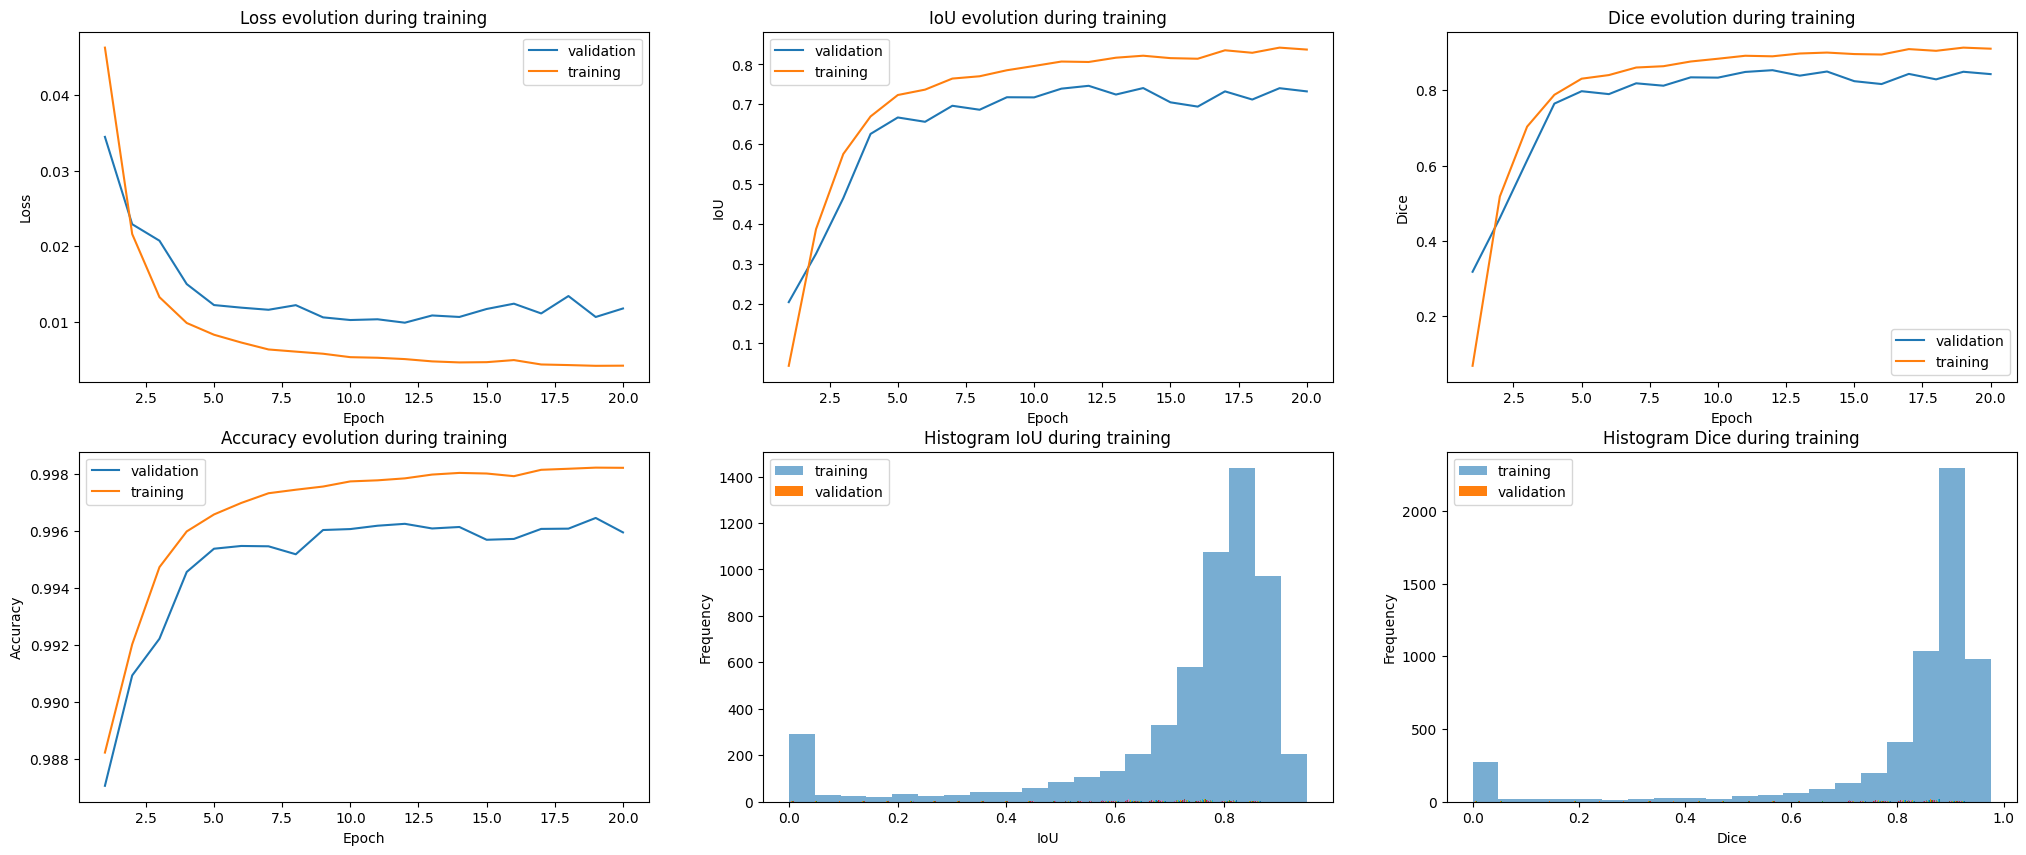

In [26]:
show_curves(curves0_1)

### Learning Rate (dropout 0.5, batch size 16, epochs 15, BCE loss, threshold 0.5, UNetSkip)

#### Learning Rate = 0.01, Dropout = 0.5

In [39]:
lr = 1e-2
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves1 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.27753910286860034 
Train acc:	 0.85474647175182
Train IoU:	 0.000529062020625021
Train Dice:	 0.0010520017255054757
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.17555302434733935 
Train acc:	 0.9183249700637091
Train IoU:	 0.0002771277250892967
Train Dice:	 0.0005510485228838206
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.13697464223350247 
Train acc:	 0.9407978057861328
Train IoU:	 0.00018773168473791067
Train Dice:	 0.0003732909348567817
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.11621533906677874 
Train acc:	 0.9524878990359422
Train IoU:	 0.00014194346894817636
Train Dice:	 0.00028224436537951784
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.10342919994510856 
Train acc:	 0.9595780840107039
Train IoU:	 0.00011411141621323982
Train Dice:	 0.0002269023329521614
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.09469667296917712 
Train acc:	 0.9643229031171955
Train IoU:	 9.5

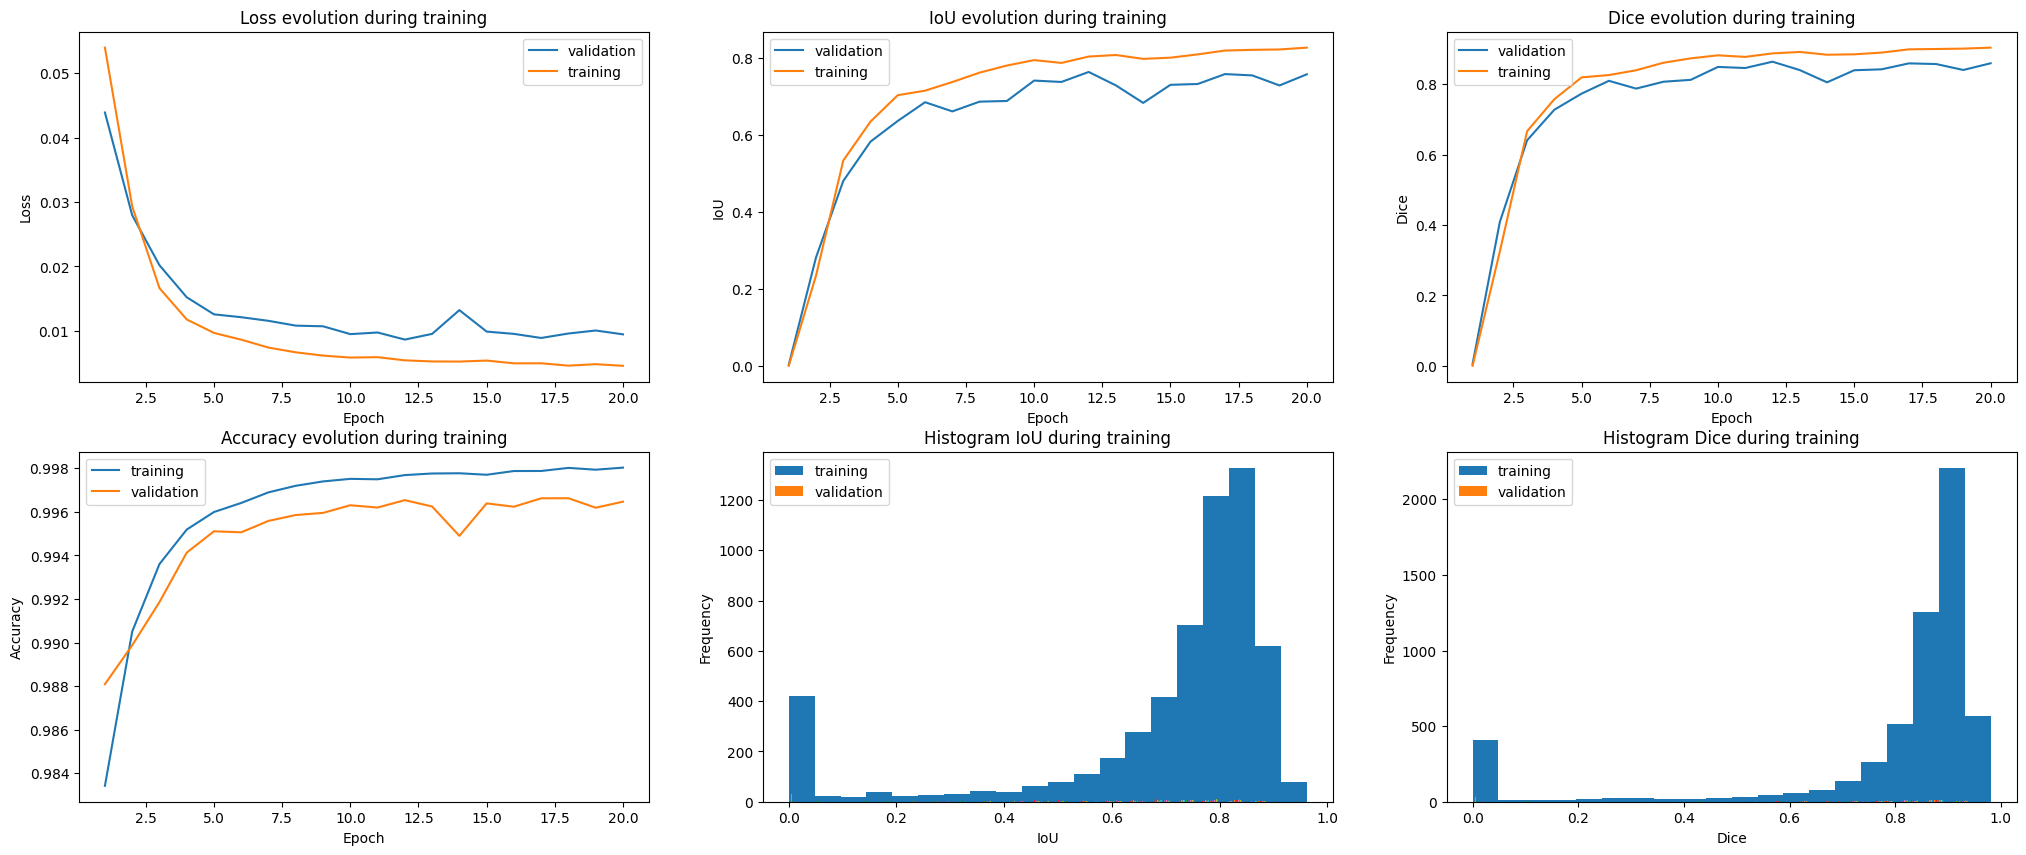

In [40]:
show_curves(curves1)

#### Learning Rate = 0.001, Dropout = 0.5

In [41]:
lr = 1e-3
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves1_1 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.30934345857663587 
Train acc:	 0.9760885238647461
Train IoU:	 0.0026486876956417047
Train Dice:	 0.005147402901263453
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.26352447200389134 
Train acc:	 0.9817175638108027
Train IoU:	 0.0013874078405742263
Train Dice:	 0.0026962586625665706
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.23627886704860196 
Train acc:	 0.9840312157907793
Train IoU:	 0.0009398569242599598
Train Dice:	 0.0018264978036741286
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.2168416108300046 
Train acc:	 0.985100211166754
Train IoU:	 0.000710623528098994
Train Dice:	 0.0013810105344853167
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.20150110067105761 
Train acc:	 0.9856655644435509
Train IoU:	 0.0005712855814129168
Train Dice:	 0.0011102241551744702
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.18845429381386178 
Train acc:	 0.986182400437652
Train IoU:	 0.0004776

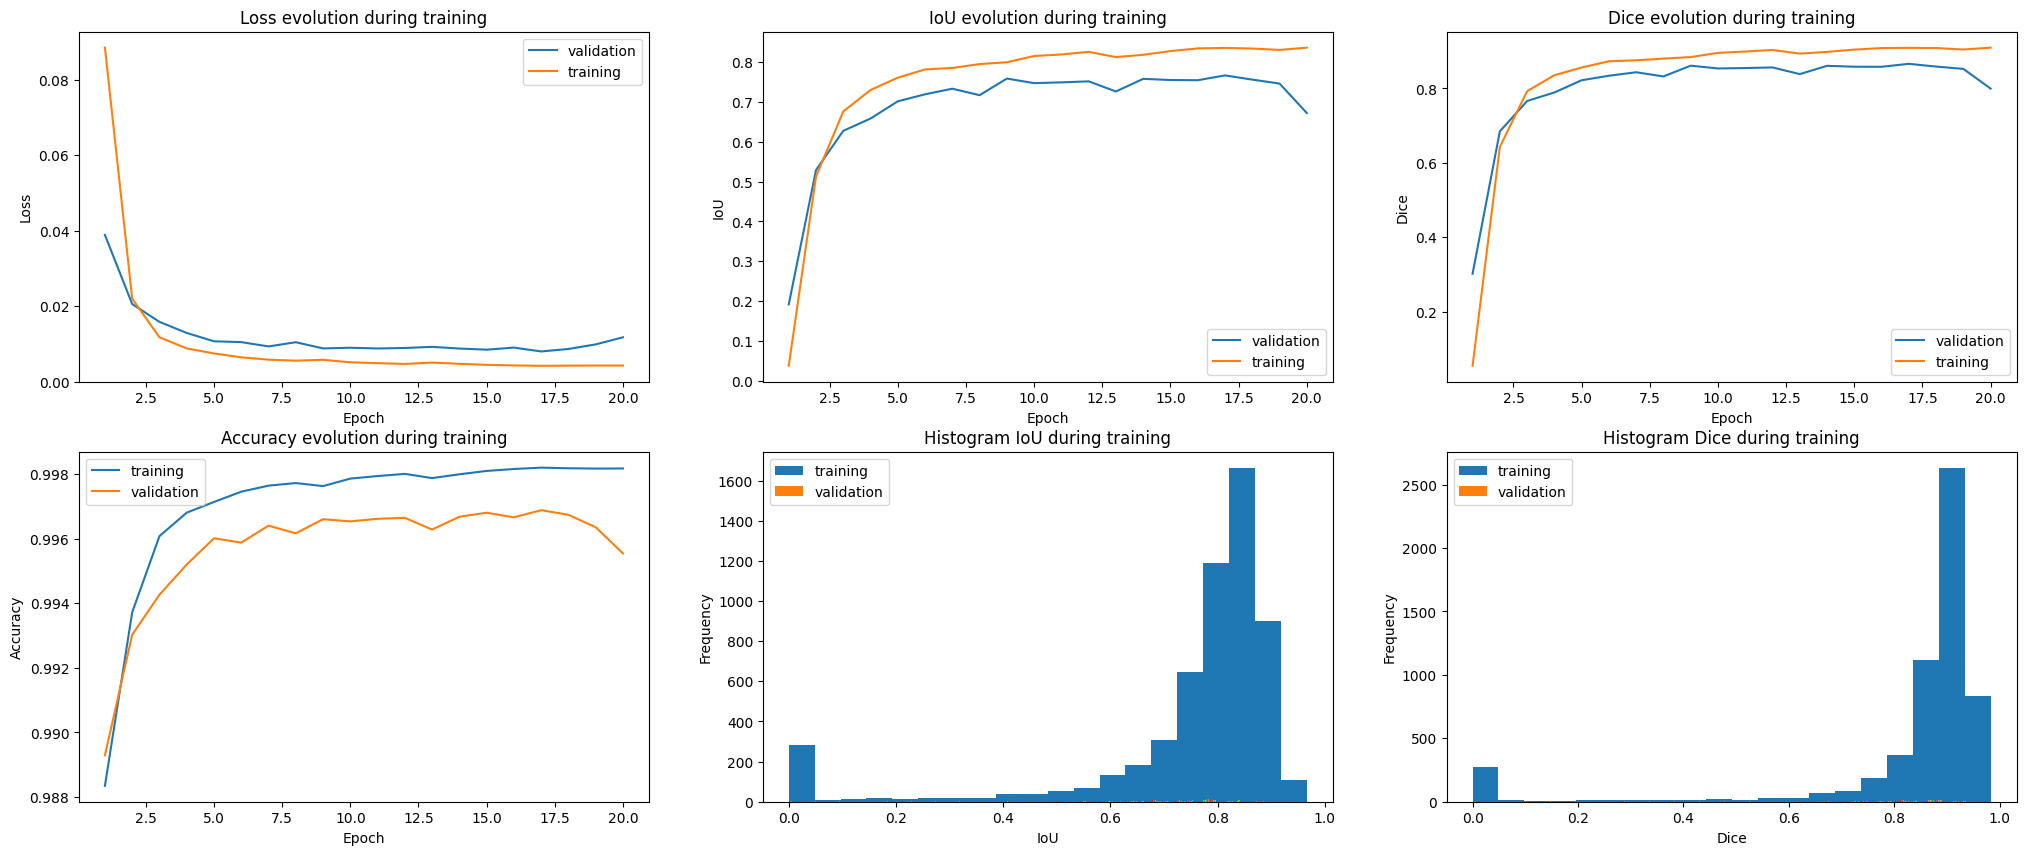

In [42]:
show_curves(curves1_1)

#### Learning Rate = 0.0001, Dropout = 0.5

In [43]:
lr = 1e-4
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves1_2 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.3623231730677865 
Train acc:	 0.9877392161976207
Train IoU:	 0.001420995612104063
Train Dice:	 0.002803085098351513
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.30101181921504794 
Train acc:	 0.9886224837530226
Train IoU:	 0.000744331034911652
Train Dice:	 0.0014682826705650783
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.27039184108857184 
Train acc:	 0.9883969829928491
Train IoU:	 0.0005042242494562803
Train Dice:	 0.0009946430994150531
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.251052786300822 
Train acc:	 0.9884215564262576
Train IoU:	 0.00038124272519865103
Train Dice:	 0.0007520472215089425
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.23724362487886466 
Train acc:	 0.9885305703855028
Train IoU:	 0.0003064892496695037
Train Dice:	 0.0006045869819973852
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.22684447100905122 
Train acc:	 0.9885272354376121
Train IoU:	 0.0002562

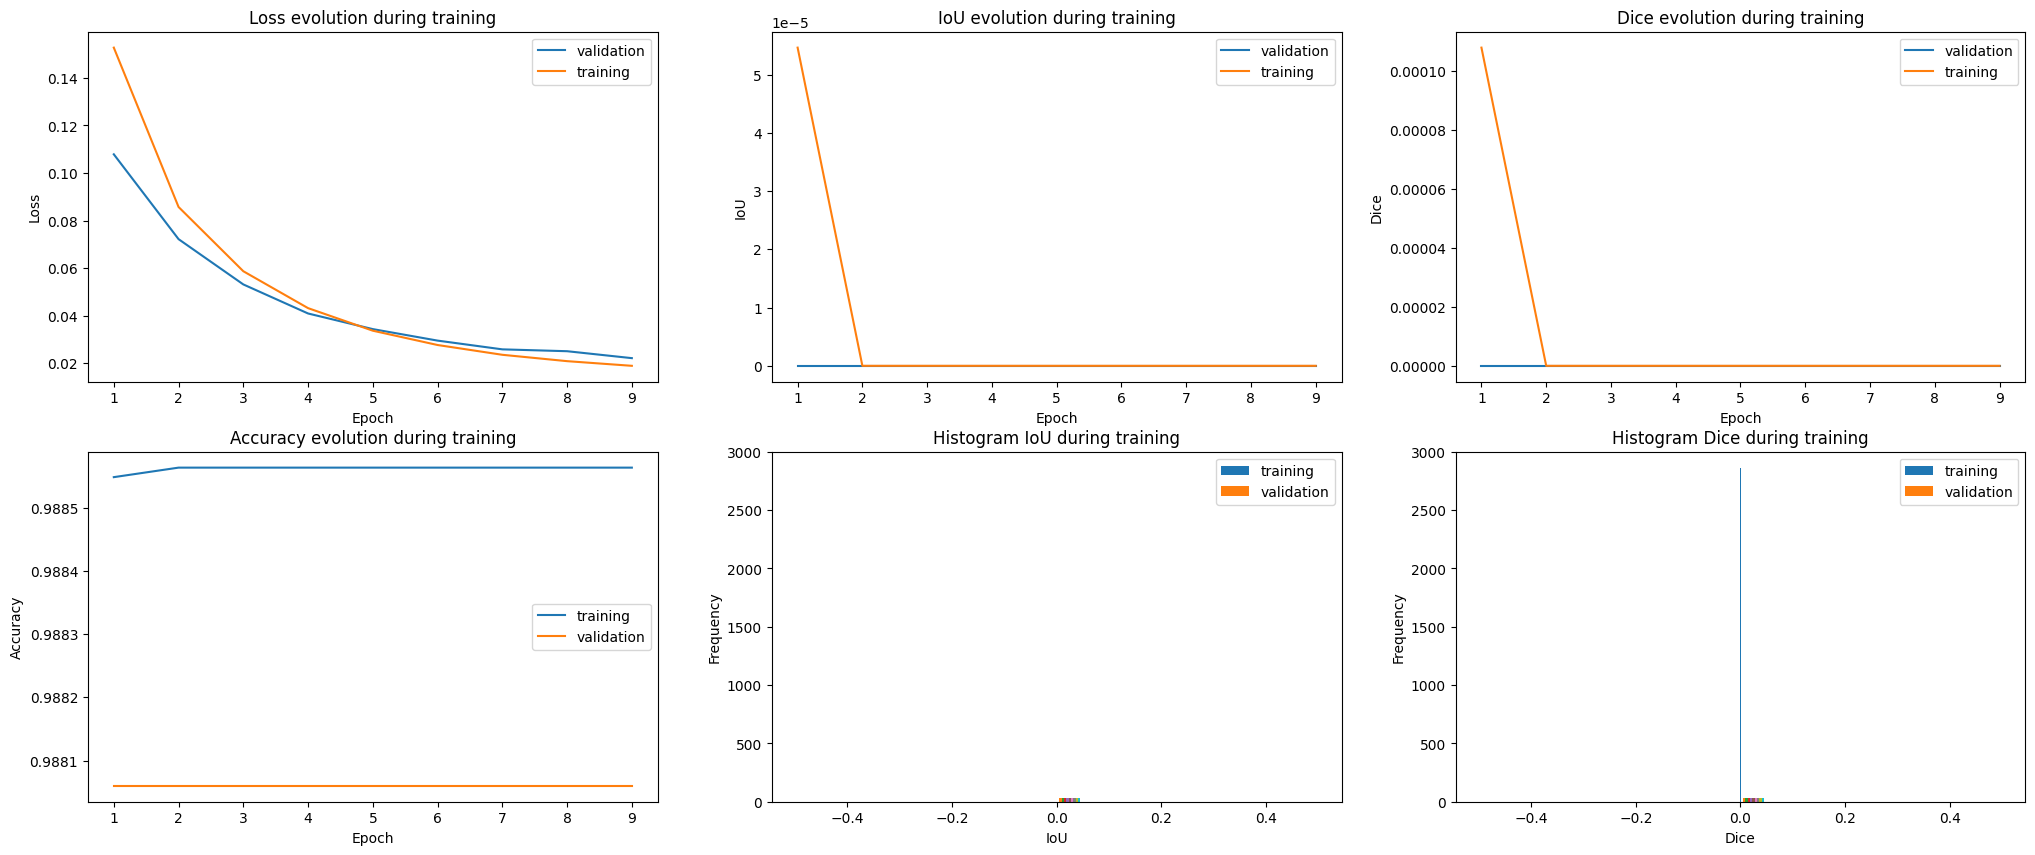

In [44]:
show_curves(curves1_2)

### Dropout (learning rate 0.001, batch size 16, epochs 15, BCE loss, threshold 0.5, UNetSkip)

#### Dropout = 0.5

In [45]:
lr = 1e-3
dropout=0.5
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves2 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.28997430069880054 
Train acc:	 0.9231641075827859
Train IoU:	 0.00112246518769524
Train Dice:	 0.002217550025627347
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.21991136315323057 
Train acc:	 0.9544149126325335
Train IoU:	 0.0005879579554594115
Train Dice:	 0.001161573822947658
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.18717878672384447 
Train acc:	 0.9654778511293473
Train IoU:	 0.0003982940988596013
Train Dice:	 0.000786872589738736
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.16717794664749286 
Train acc:	 0.9710929219315692
Train IoU:	 0.00030114919669872297
Train Dice:	 0.00059495244590002
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.15297860681426292 
Train acc:	 0.9745266297284294
Train IoU:	 0.00024210033460093415
Train Dice:	 0.0004782951035666827
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.1423546596140158 
Train acc:	 0.9767368347918401
Train IoU:	 0.00020241

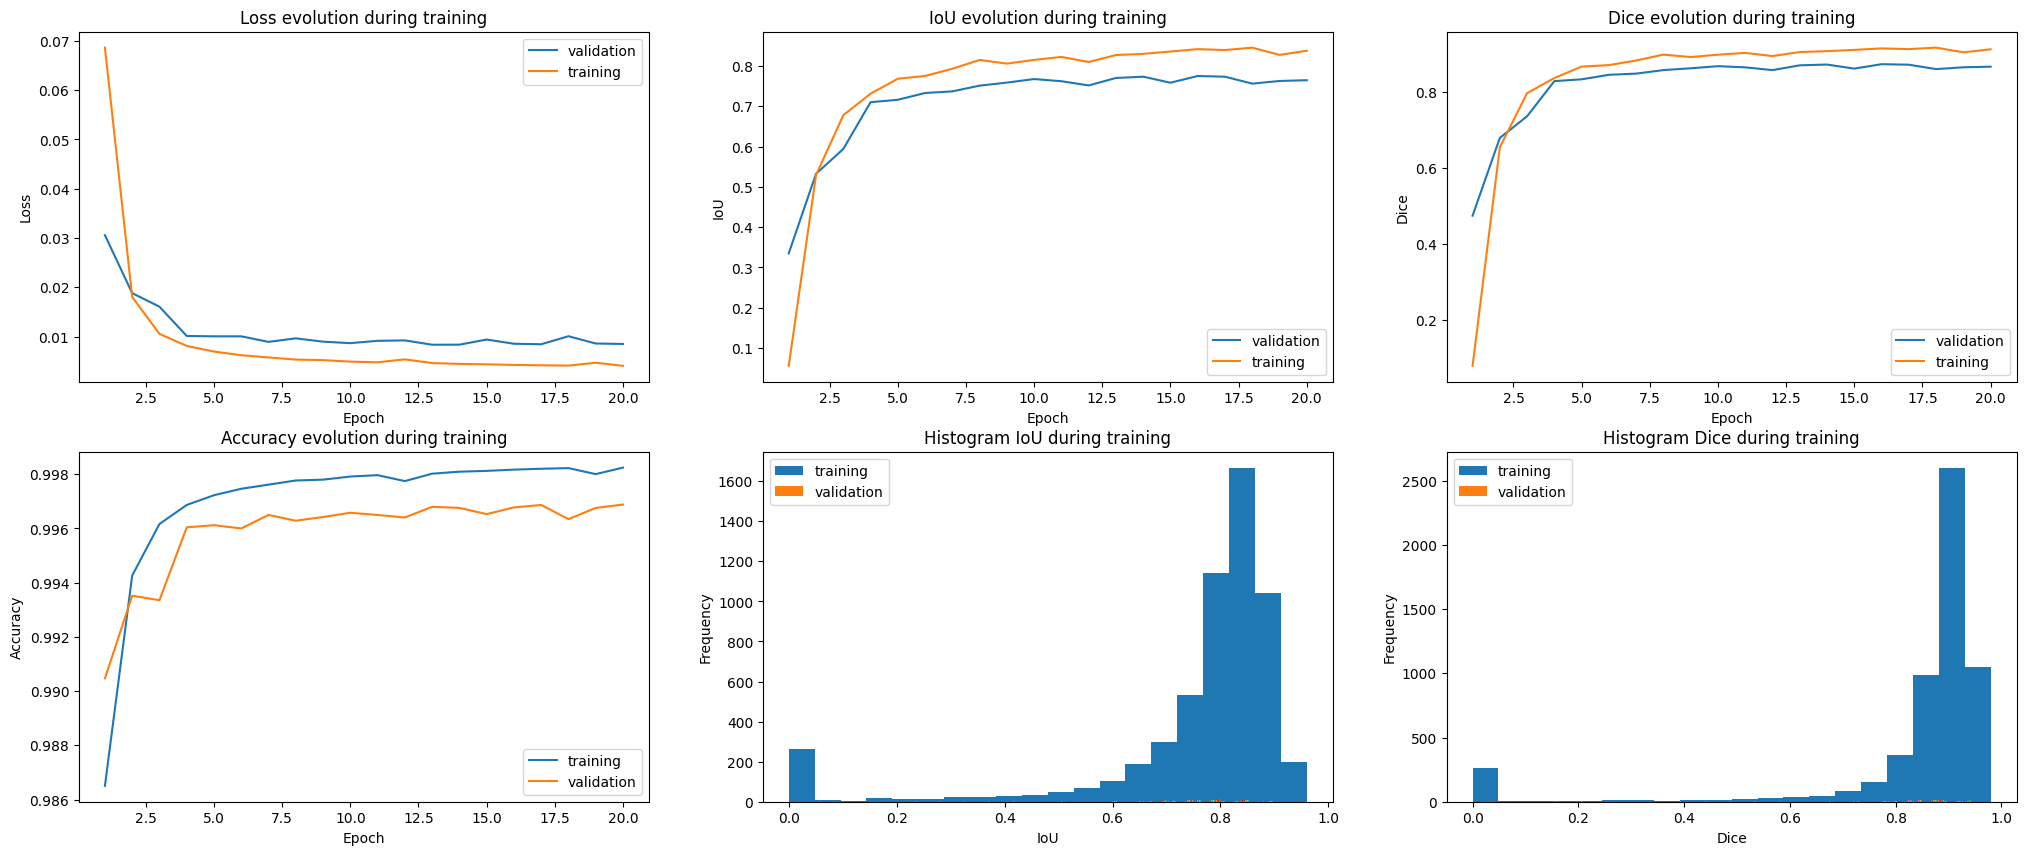

In [46]:
show_curves(curves2)

#### Dropout = 0.7

In [49]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves2_2 = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.25510207360441034 
Train acc:	 0.9828802455555309
Train IoU:	 0.0019924010749698823
Train Dice:	 0.003899342552709136
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.20504546094508397 
Train acc:	 0.9855123701549712
Train IoU:	 0.0010436386583175573
Train Dice:	 0.0020425127657047854
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.18088656303382689 
Train acc:	 0.9864934798209898
Train IoU:	 0.0007069810266022163
Train Dice:	 0.0013836376799935643
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.1647821646638033 
Train acc:	 0.987064547655059
Train IoU:	 0.0005345466298699685
Train Dice:	 0.0010461650751170852
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.15251296028202654 
Train acc:	 0.9874912149765912
Train IoU:	 0.00042973356518958243
Train Dice:	 0.0008410346682313823
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.1428607262548853 
Train acc:	 0.9877223499485703
Train IoU:	 0.00035

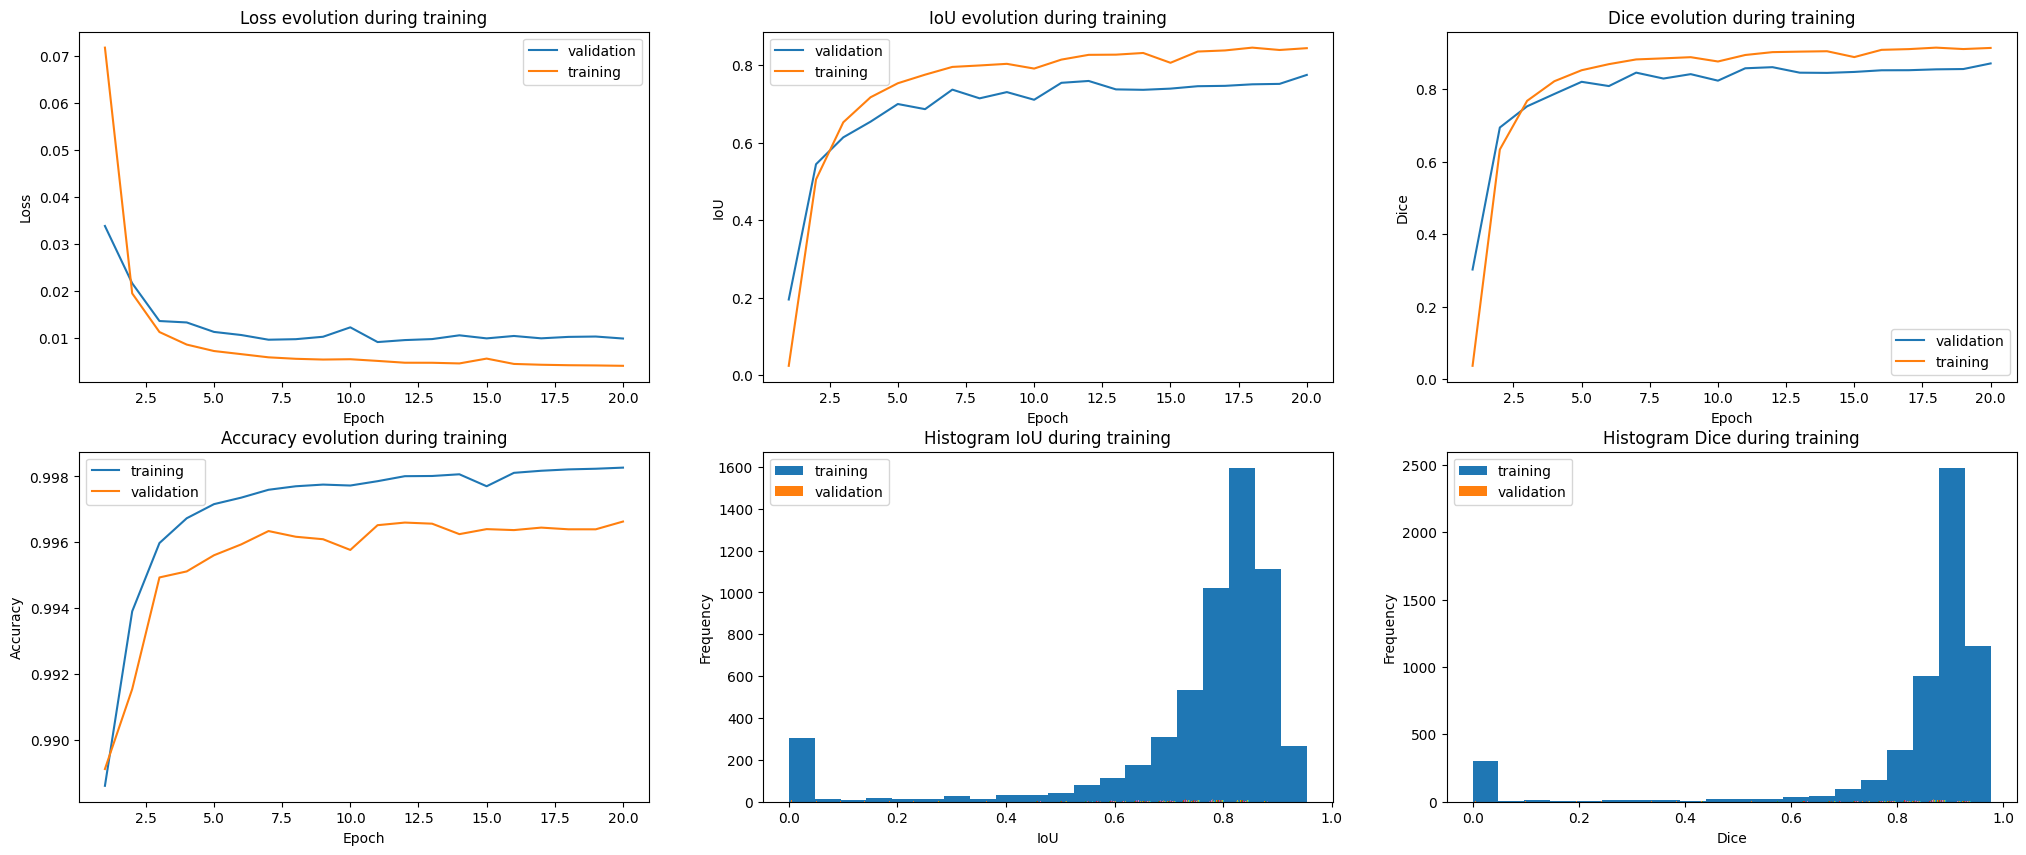

In [50]:
show_curves(curves2_2)

#### Dropout = 0.8

In [20]:
lr = 1e-3
dropout=0.8
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves2_3= train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.27469778060913086 
Train acc:	 0.9535226821899414
Train IoU:	 0.002668451544554719
Train Dice:	 0.005184716283195749
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.2166788847673507 
Train acc:	 0.9698585782732282
Train IoU:	 0.0013977603328619956
Train Dice:	 0.0027158037673882494
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.1891796379800766 
Train acc:	 0.975816419047694
Train IoU:	 0.0009468699029065132
Train Dice:	 0.001839738035972685
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.170615132988953 
Train acc:	 0.9791591923411299
Train IoU:	 0.000715926024148827
Train Dice:	 0.0013910214418330058
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.15726281717127444 
Train acc:	 0.981046059552361
Train IoU:	 0.0005755483723549394
Train Dice:	 0.0011182721395128084
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.1465045748675456 
Train acc:	 0.9824154963258838
Train IoU:	 0.0004811961801

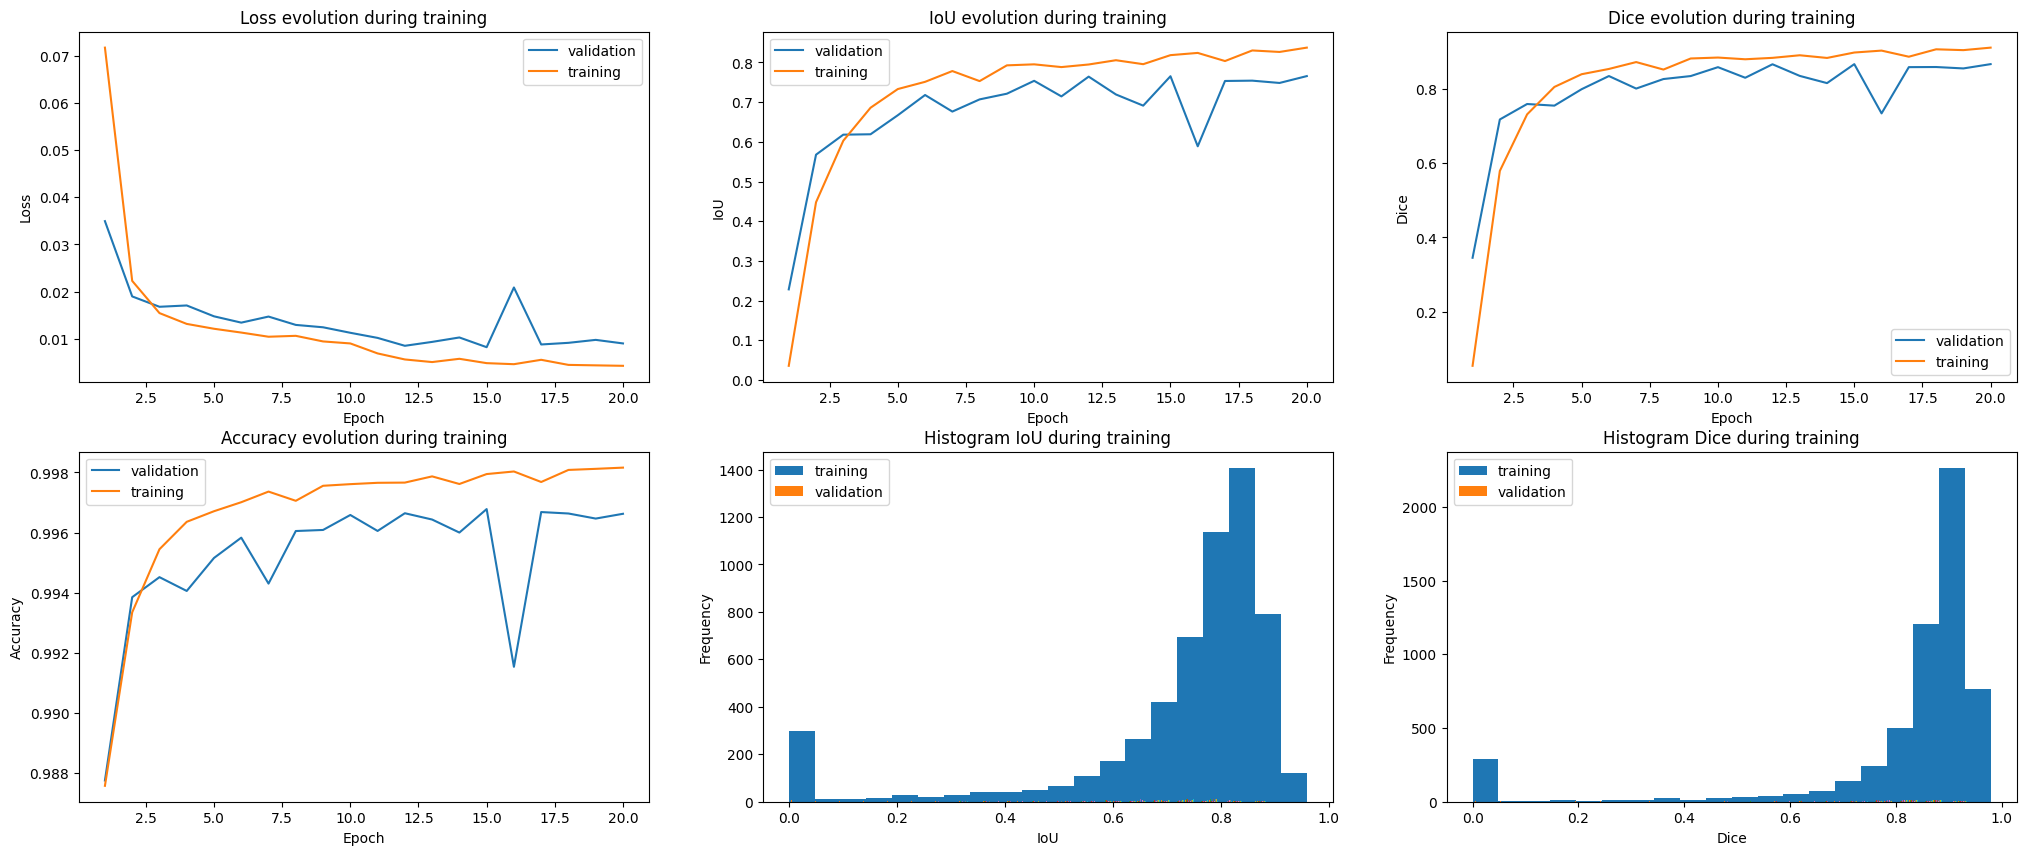

In [21]:
show_curves(curves2_3)

### Threshold (learning rate 0.001, dropout 0.7, batch size 16, epochs 20, BCE loss, UNetSkip)

#### Threshold = 0.5

In [22]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 20
threshold=0.5
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves3_1= train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.28969696976921777 
Train acc:	 0.9581499099731445
Train IoU:	 0.0009721116020459769
Train Dice:	 0.0019236531431653383
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.23469808059079306 
Train acc:	 0.9724879946027484
Train IoU:	 0.0005092013153574165
Train Dice:	 0.0010076278368961297
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.2073034591251804 
Train acc:	 0.9776171099755072
Train IoU:	 0.00034494282653244344
Train Dice:	 0.0006825865991877008
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.18900048114904544 
Train acc:	 0.9802339367750215
Train IoU:	 0.00026081042981721333
Train Dice:	 0.0005161020628004566
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.1749271626273791 
Train acc:	 0.9819001403509402
Train IoU:	 0.00020967112985305385
Train Dice:	 0.00041490557989840634
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.16349616988760526 
Train acc:	 0.9830529259853675
Train IoU:	 0.

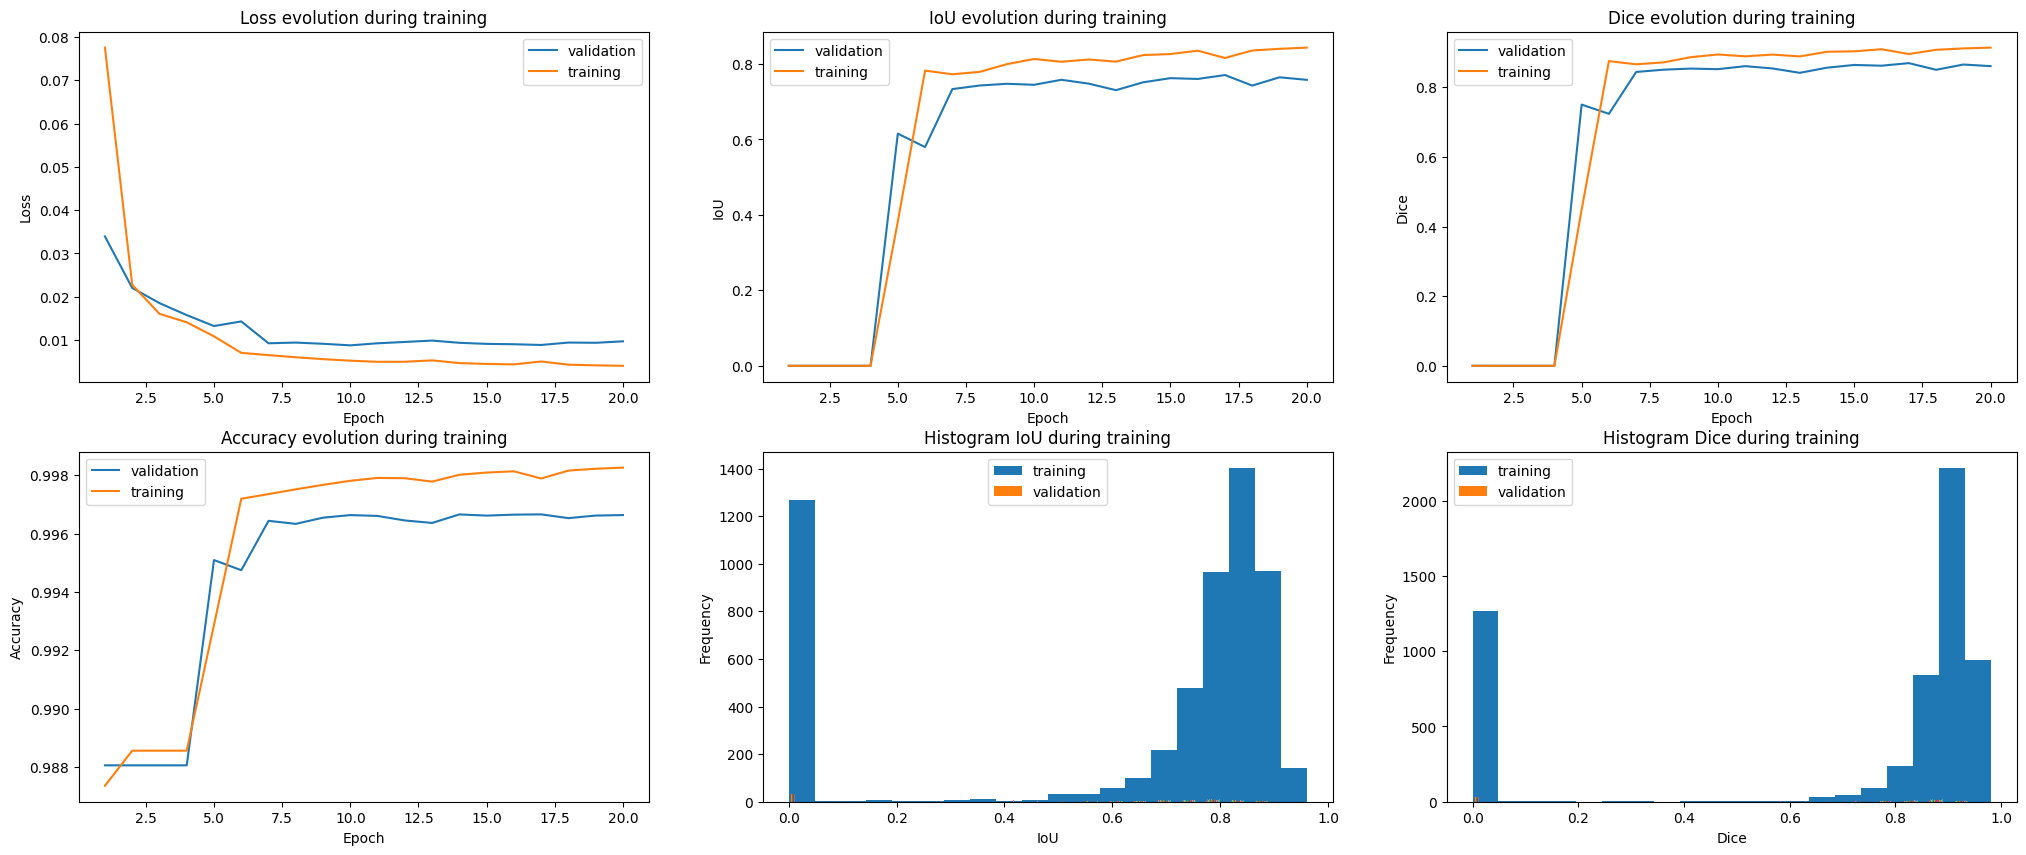

In [23]:
show_curves(curves3_1)

#### Threshold = 0.7

In [24]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 20
threshold=0.7
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves3_2= train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.37731711024587805 
Train acc:	 0.9770784378051758
Train IoU:	 0.006337819536143558
Train Dice:	 0.01184953660201185
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.29587636958985103 
Train acc:	 0.9824659256708055
Train IoU:	 0.0033198102332180545
Train Dice:	 0.006206900124863349
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.2529729484550415 
Train acc:	 0.9841996162168442
Train IoU:	 0.002248903706373521
Train Dice:	 0.004204674278133236
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.22511097897843615 
Train acc:	 0.9852394941376477
Train IoU:	 0.001700390607258028
Train Dice:	 0.003179143966393423
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.20522717444920072 
Train acc:	 0.9858748305077646
Train IoU:	 0.0013669806842662576
Train Dice:	 0.0025557824043554965
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.18987968783886705 
Train acc:	 0.9863221215420082
Train IoU:	 0.00114288549

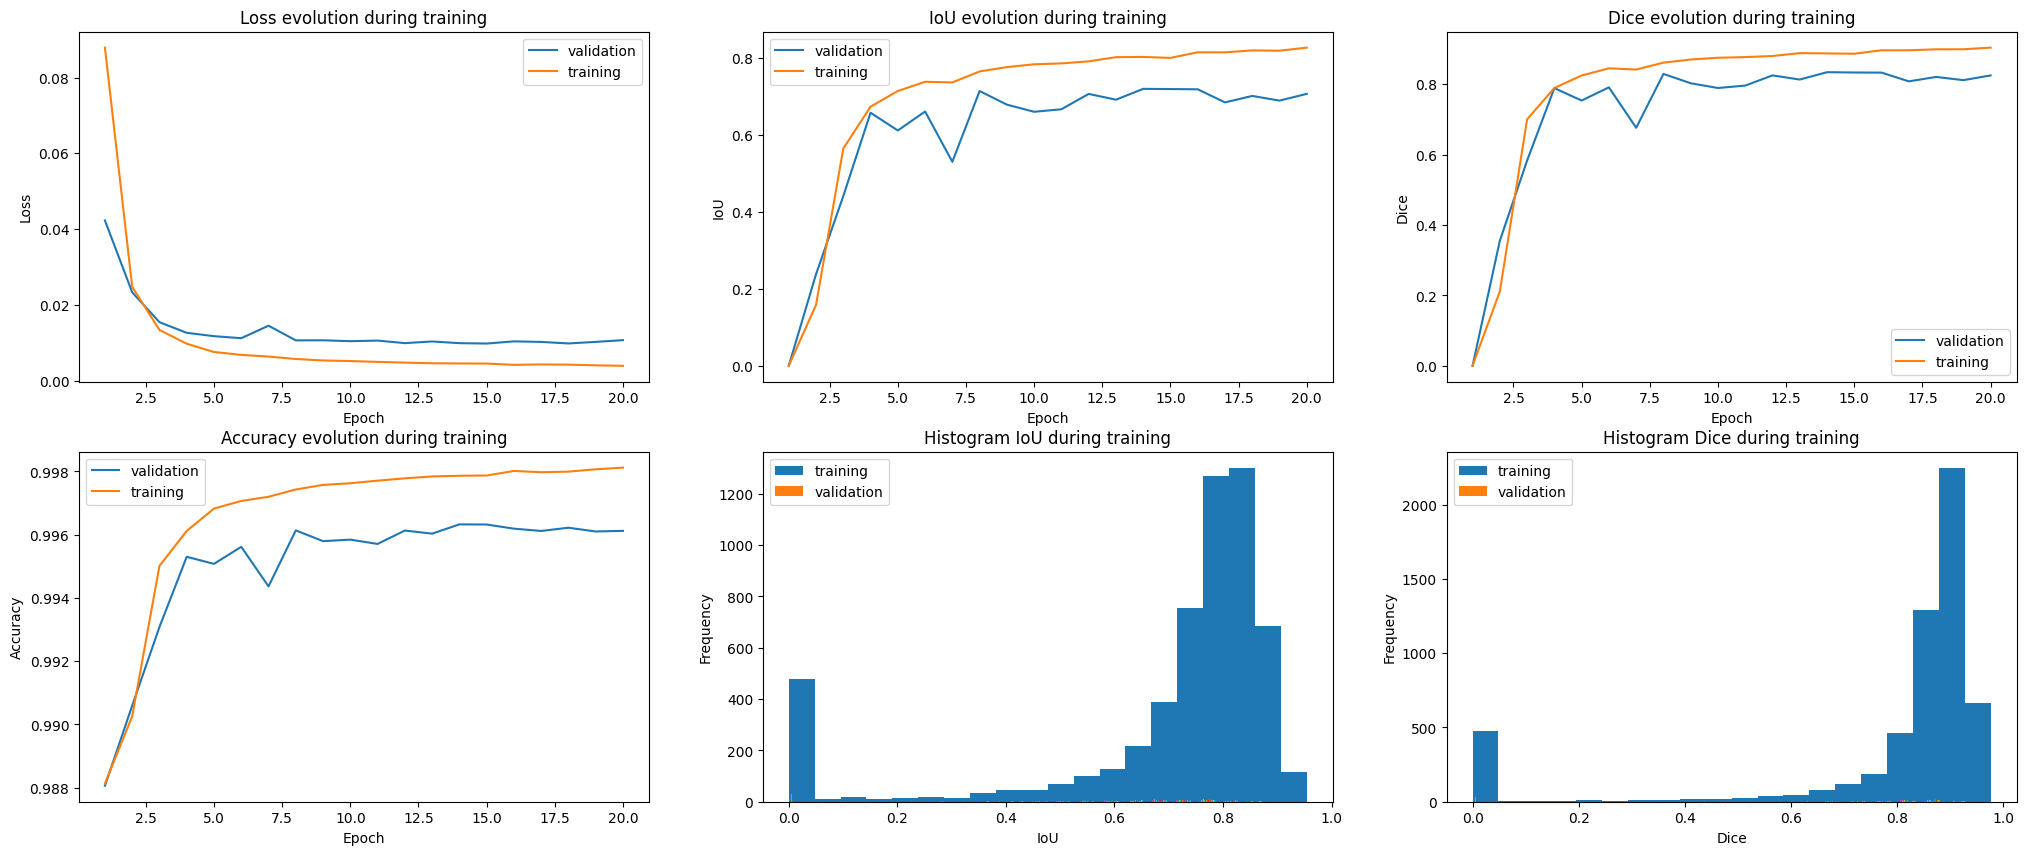

In [25]:
show_curves(curves3_2)

#### Threshold = 0.8

In [26]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 20
threshold=0.8
criteria='iou'
use_gpu=True

model = UNetSkip(dropout)
model = model.to(device)
criterion = nn.BCELoss()

curves3_3= train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/20
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.3083324147896333 
Train acc:	 0.9889279278841886
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.2619414592073077 
Train acc:	 0.9884886968703497
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.236009735734232 
Train acc:	 0.9884823522260112
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.2172546237707138 
Train acc:	 0.9884022270760885
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.20210423130615085 
Train acc:	 0.9884194579778933
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.1893967942136233 
Train acc:	 0.9884408106569385
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 70 - Batch 70/286
Train loss: 	 0.1784823057307324 
Train acc:	 0.9884623406638562
Train IoU:	 0.0
Train Dice:	 0.0
Epoch 1 - Iteration 80 - Batch 80

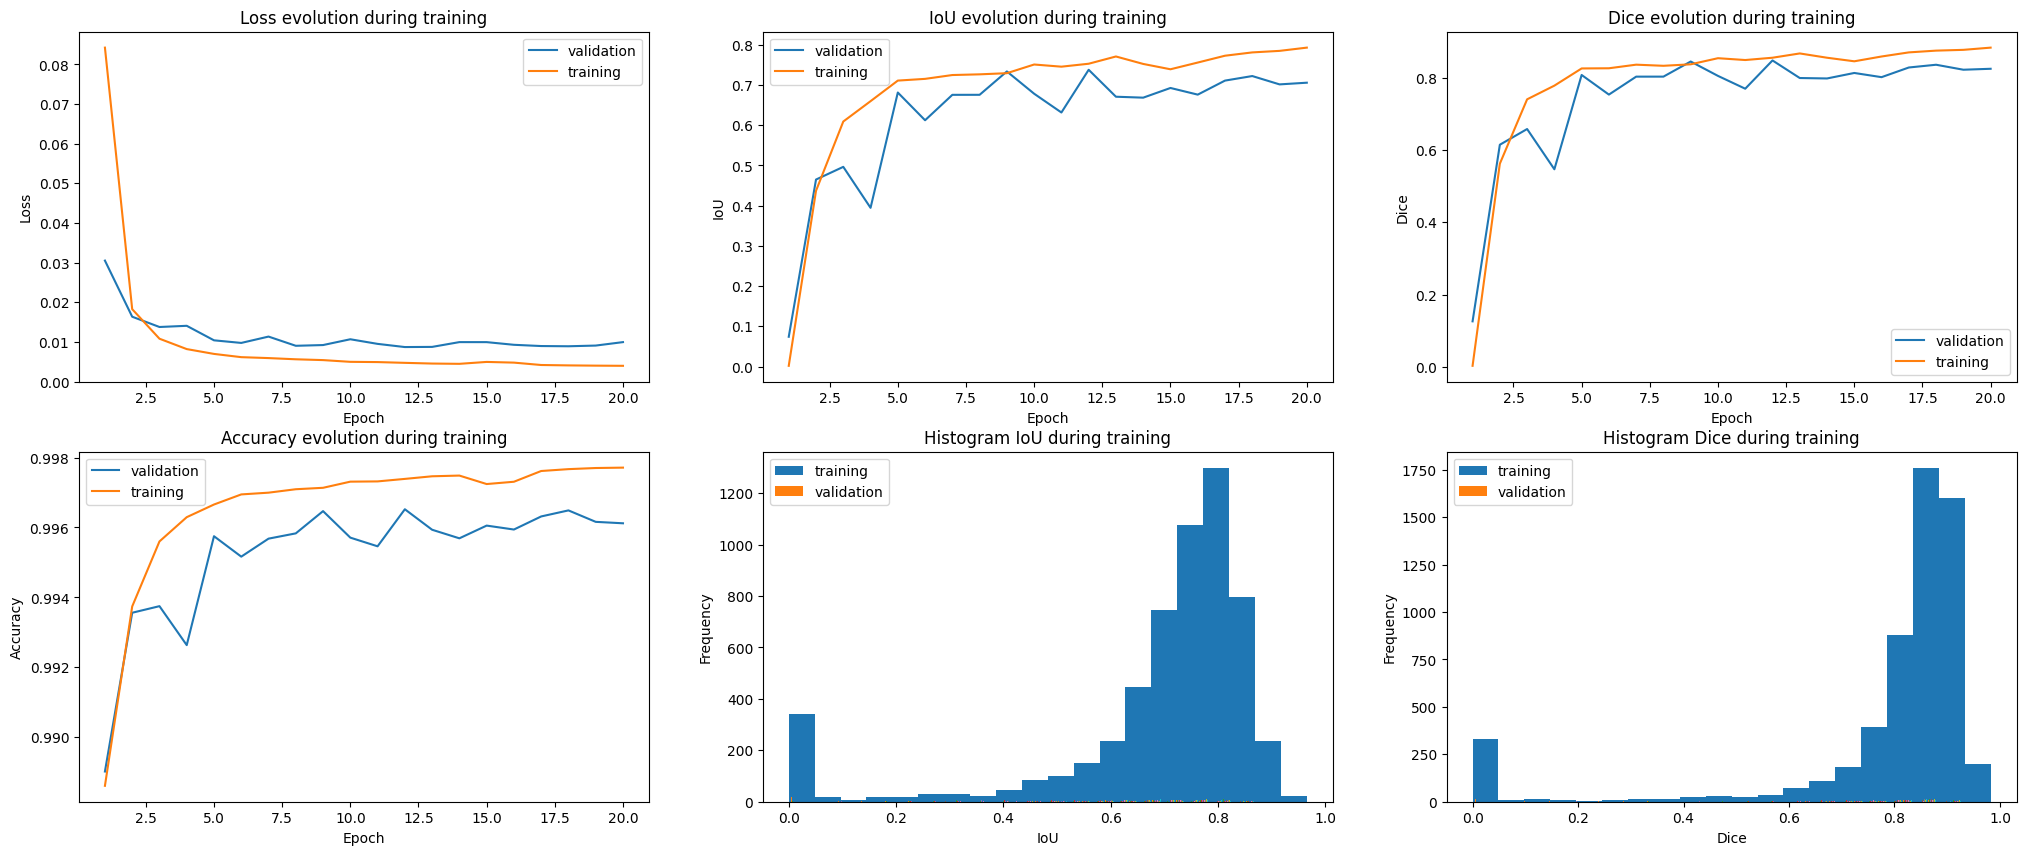

In [27]:
show_curves(curves3_3)

### Mejor modelo

In [19]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 40
threshold=0.5
criteria='iou'
use_gpu=True

model1 = UNetSkip(dropout)
model1 = model.to(device)
criterion = nn.BCELoss()

curvesbest= train_model(
    model1,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/40
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.4023859202861786 
Train acc:	 0.8895971124822443
Train IoU:	 0.0015199931923084824
Train Dice:	 0.002989993910340588
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.33900172511736554 
Train acc:	 0.9367876961117699
Train IoU:	 0.0007961869102568241
Train Dice:	 0.0015661872863688793
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.3051334927158971 
Train acc:	 0.9534570324805475
Train IoU:	 0.0005393524230772035
Train Dice:	 0.0010609655810885957
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.28078960899899646 
Train acc:	 0.9618460492389959
Train IoU:	 0.0004078030515949587
Train Dice:	 0.0008021934881401577
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.2612453059238546 
Train acc:	 0.9669211705525717
Train IoU:	 0.0003278416689292805
Train Dice:	 0.000644900647328362
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.24436203329289546 
Train acc:	 0.9705848381167552
Train IoU:	 0.0002740

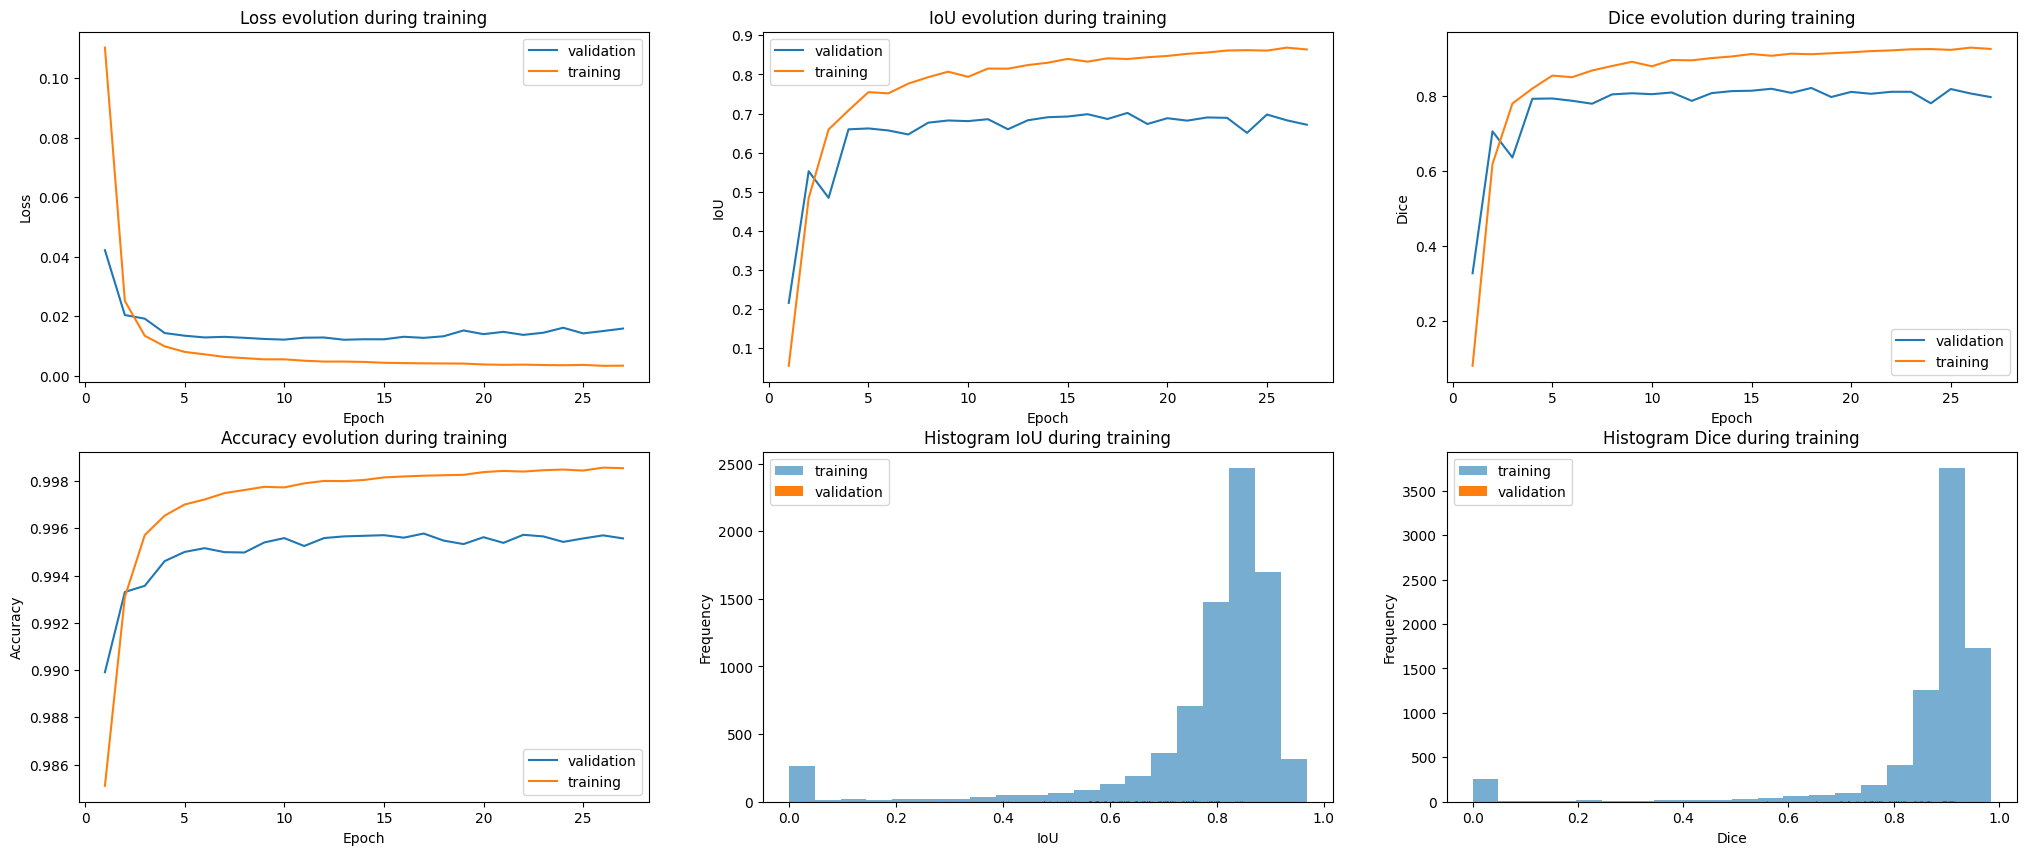

In [20]:
show_curves(curvesbest)

In [23]:
lr = 1e-3
dropout=0.7
batch_size=16
epochs= 40
threshold=0.8
criteria='iou'
use_gpu=True

model2 = UNetSkip(dropout)
model2 = model.to(device)
criterion = nn.BCELoss()

curvesbest2= train_model(
    model2,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/40
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.003976250681179491 
Train acc:	 0.997696269642223
Train IoU:	 0.7786395834866493
Train Dice:	 0.8684188993391225
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.003687330310986865 
Train acc:	 0.9978859311058408
Train IoU:	 0.8103352791988273
Train Dice:	 0.8907115104402055
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.003542885274416016 
Train acc:	 0.9979644283171623
Train IoU:	 0.805402153969567
Train Dice:	 0.8887181983016263
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.0034411134164235215 
Train acc:	 0.9980328722697932
Train IoU:	 0.813304041801448
Train Dice:	 0.8942277098630824
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.0033693902021018312 
Train acc:	 0.9980799731086282
Train IoU:	 0.81982803566741
Train Dice:	 0.8985949312618298
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.0033428839438396397 
Train acc:	 0.9980926044651719
Train IoU:	 0.8248489695489308
Train Dice:

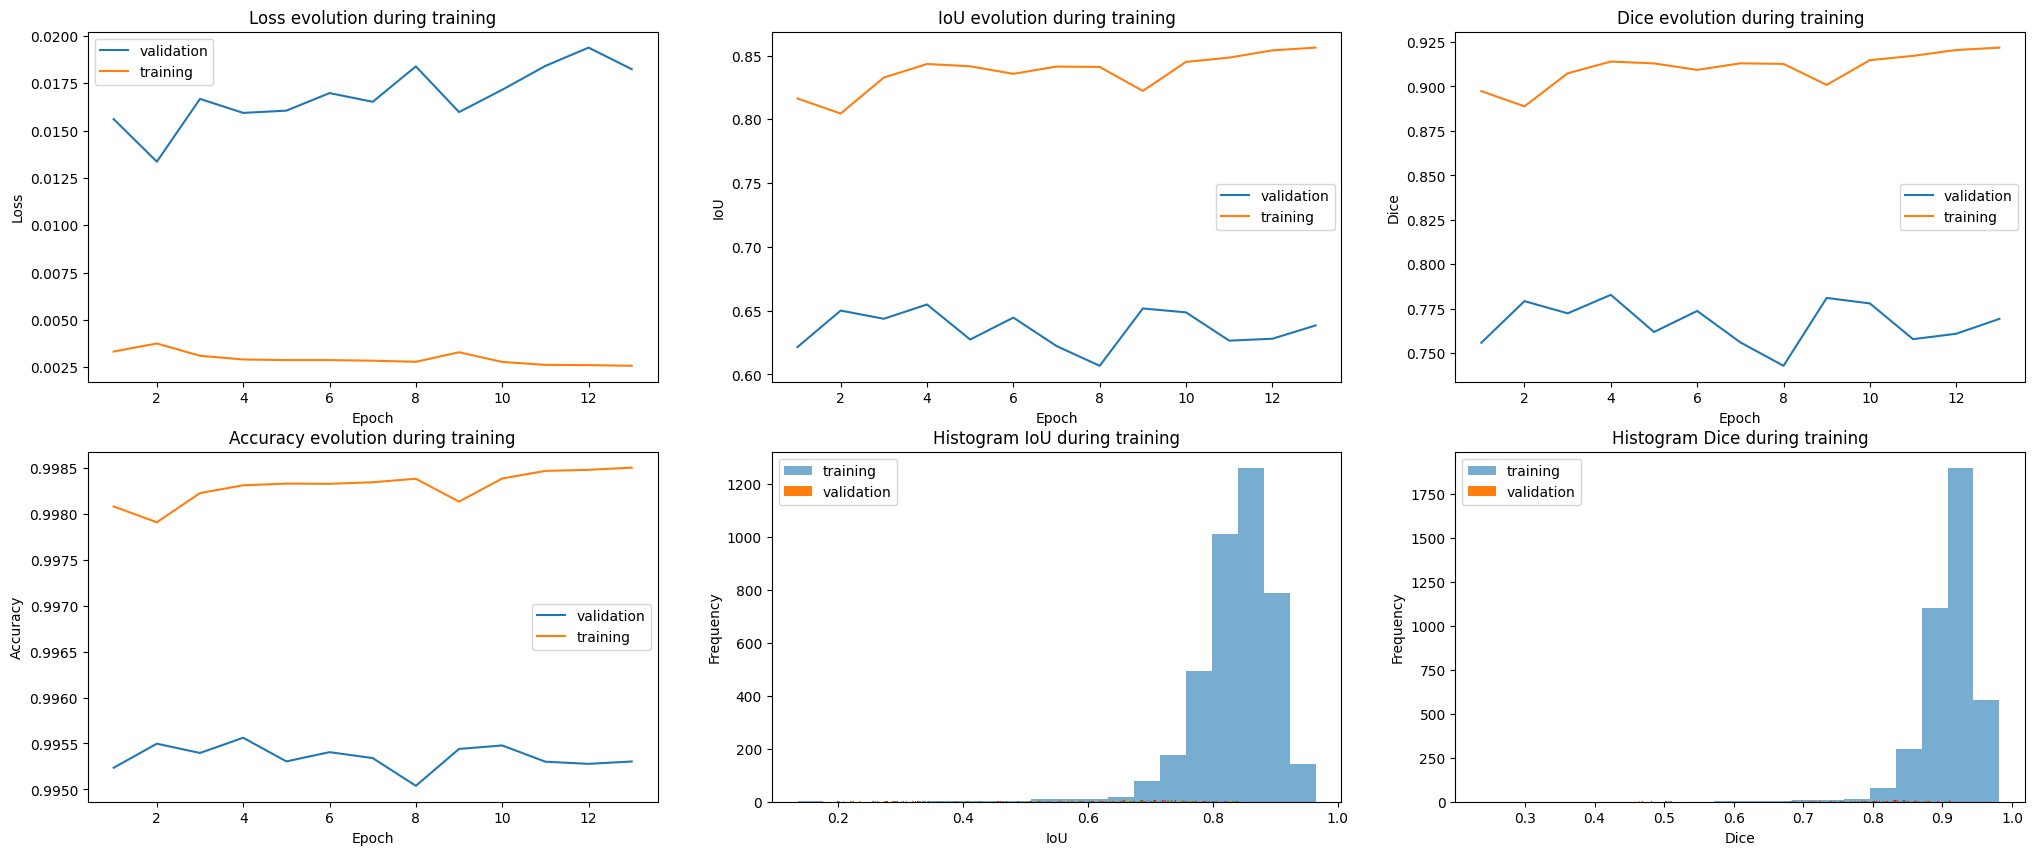

In [27]:
show_curves(curvesbest2)

In [20]:
lr = 1e-3
dropout=0.5
batch_size=16
epochs= 40
threshold=0.5
criteria='iou'
use_gpu=True

model3 = UNetSkip(dropout)
model3 = model.to(device)
criterion = nn.BCELoss()

curvesbest3= train_model(
    model3,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    criteria=criteria,
    use_gpu=use_gpu,
    threshold=threshold,
)

502
Epoch 1/40
Epoch 1 - Iteration 10 - Batch 10/286
Train loss: 	 0.20885466716506265 
Train acc:	 0.9750530936501243
Train IoU:	 0.0008843978214041786
Train Dice:	 0.0017517539219342139
Epoch 1 - Iteration 20 - Batch 20/286
Train loss: 	 0.16556422660748163 
Train acc:	 0.9818409056890578
Train IoU:	 0.00046325600168790307
Train Dice:	 0.0009175853876798262
Epoch 1 - Iteration 30 - Batch 30/286
Train loss: 	 0.14614746359086805 
Train acc:	 0.9839598132717994
Train IoU:	 0.0003138185817885795
Train Dice:	 0.0006215901013314952
Epoch 1 - Iteration 40 - Batch 40/286
Train loss: 	 0.13408555217632434 
Train acc:	 0.9848400209008193
Train IoU:	 0.00023727746427916986
Train Dice:	 0.00046998275954332567
Epoch 1 - Iteration 50 - Batch 50/286
Train loss: 	 0.12482612346317254 
Train acc:	 0.9854983722462374
Train IoU:	 0.0001907524712832542
Train Dice:	 0.00037782927727992845
Epoch 1 - Iteration 60 - Batch 60/286
Train loss: 	 0.11774912867389742 
Train acc:	 0.9858580417320376
Train IoU:	 

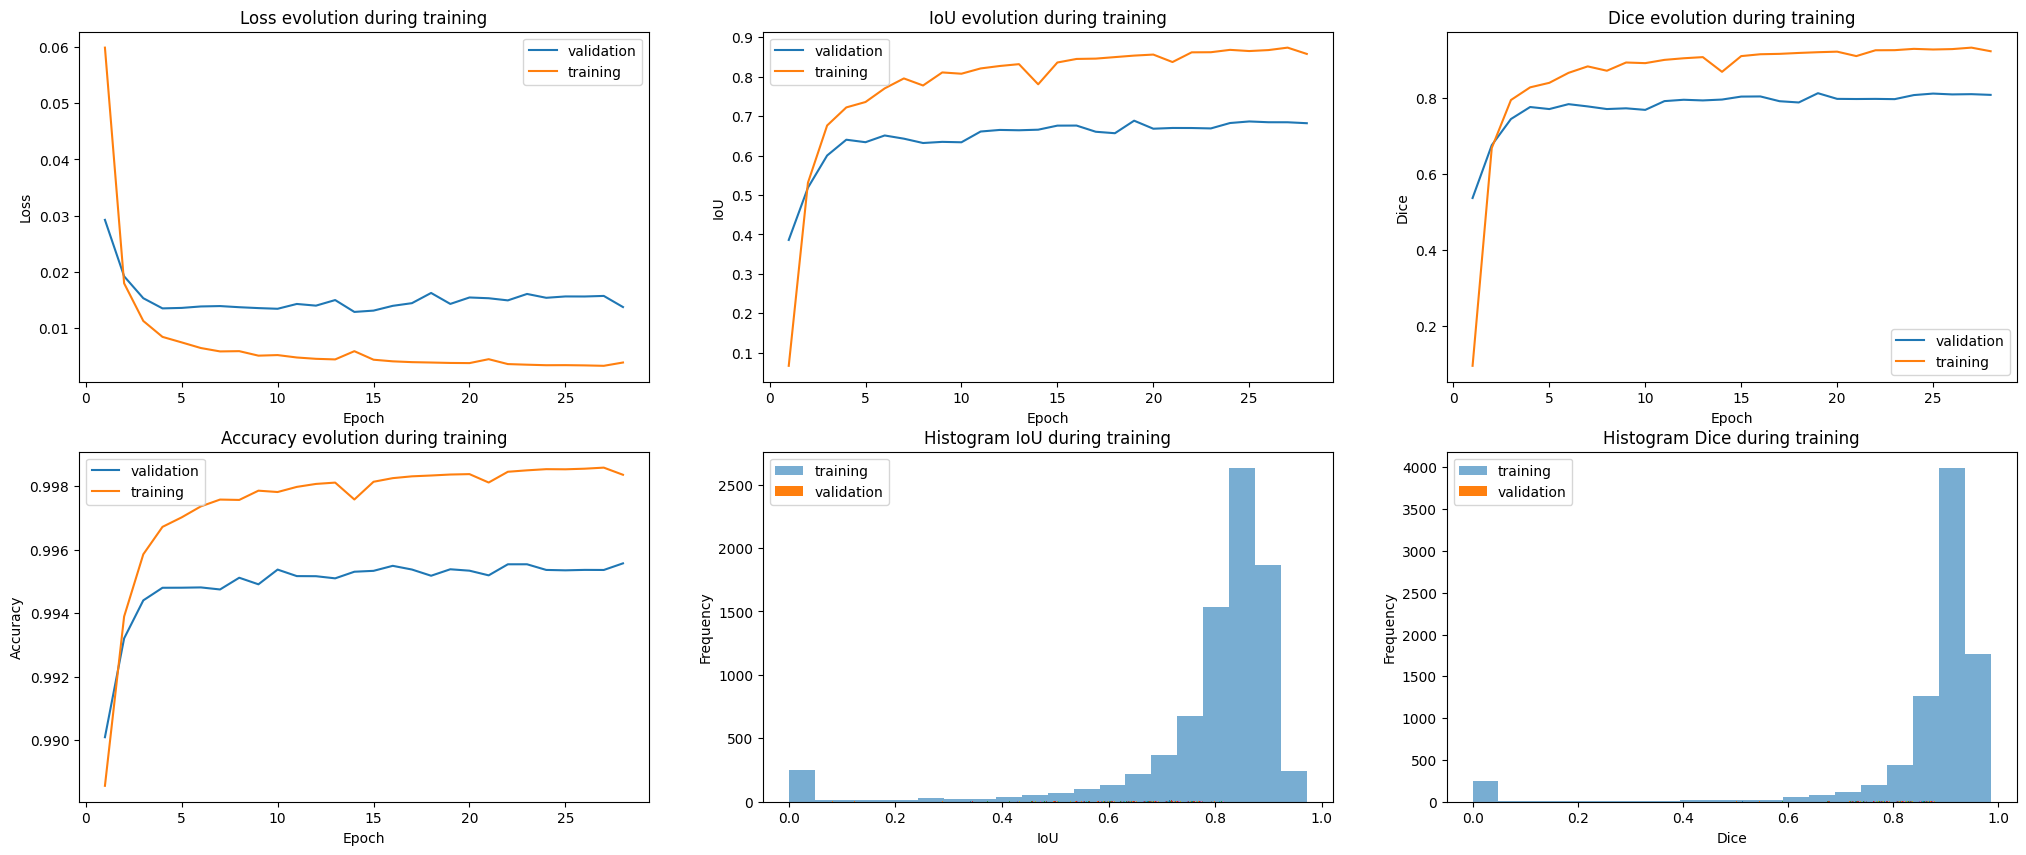

In [21]:
show_curves(curvesbest3)

## Análisis de resultados

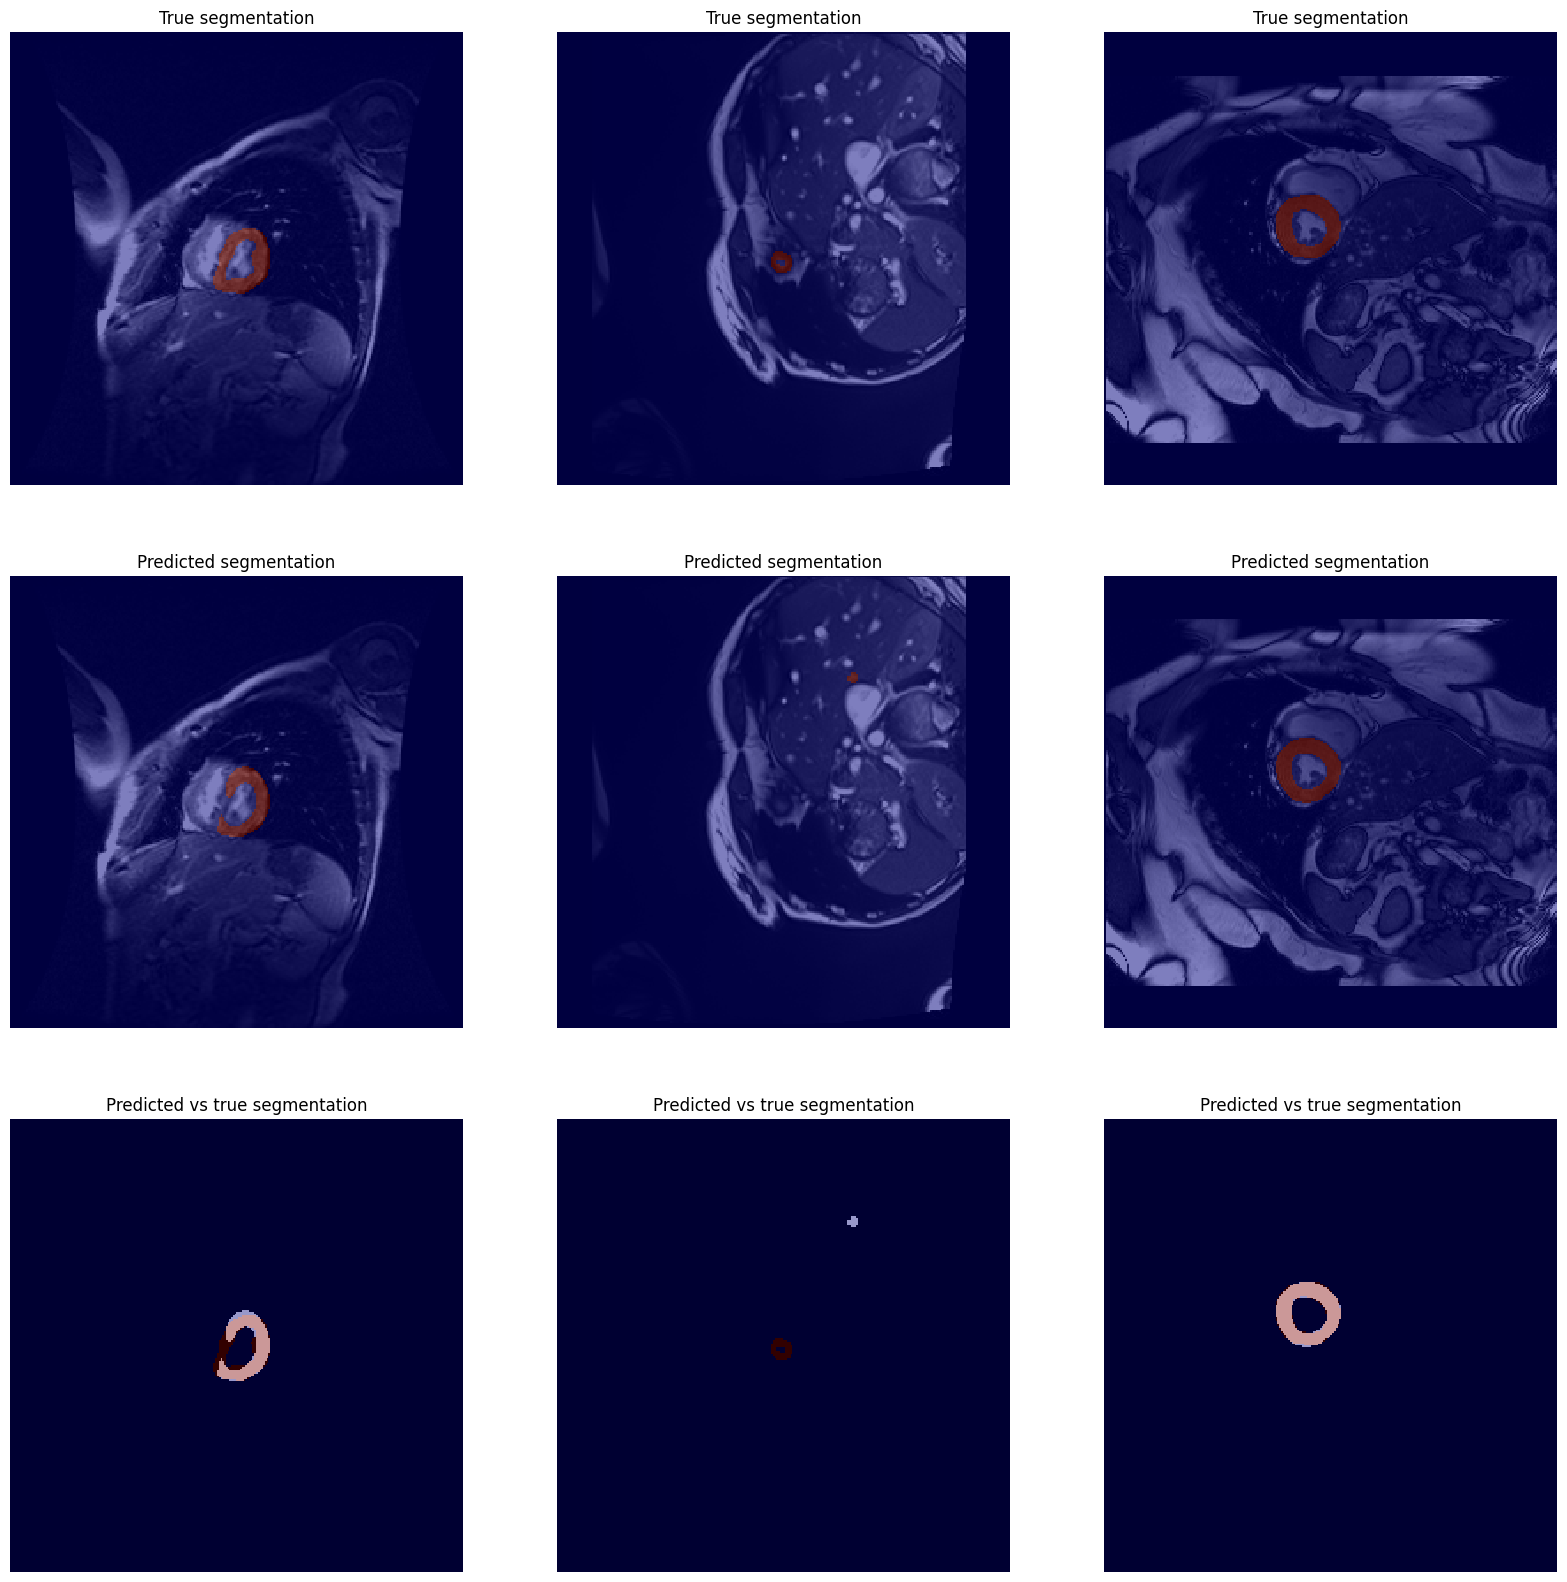

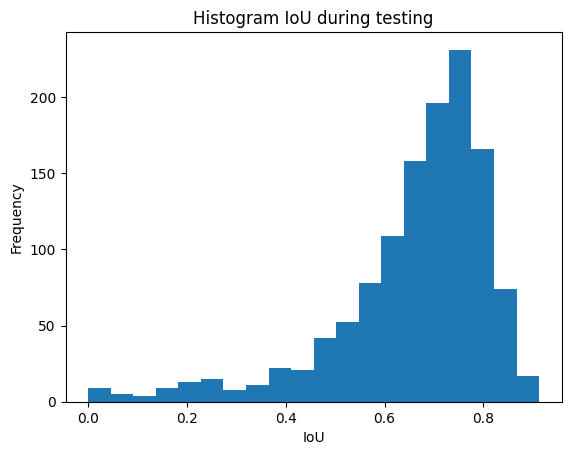

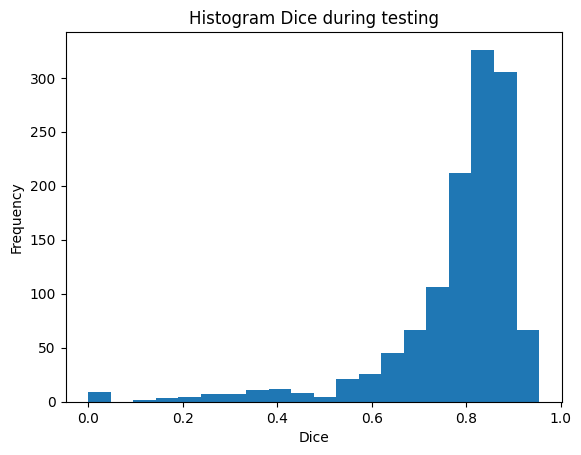

IoU promedio: 66.09 %
IoU desv: 15.83 %
IoU max: 91.3 %
IoU min: 0.0 %
Dice promedio: 78.22 %
Dice desv: 14.5 %
Dice max: 95.45 %
Dice min: 0.0 %


In [22]:
import matplotlib.pyplot as plt
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model3.cuda()

test=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

threshold = 0.5
(TN, TP, FN, FP) = (0,0,0,0)
IoU = []
dice_score = []
j=1
f = plt.figure(figsize=(20, 20))

worst = 1
worst_img = 0
worst_true = 0
worst_pred = 0

best = 0
best_img = 0
best_true = 0
best_pred = 0

ran = np.random.randint(1,1240)
ran_true = 0
ran_pred = 0

for i, (x_test, y_test) in enumerate(test):
    x_test = x_test.unsqueeze(1).float()
    y_pred = model3(x_test.float().cuda()).cpu()
    y_p = (y_pred > 0.5).long()
    union = y_p

    true = y_test.detach().numpy()[0]
    pred = y_p.detach().numpy()[0][0]

    union = true + pred
    union[union > 1] = 1
    inter = true + pred - union

    dice = 2 * np.sum(inter) / (np.sum(true) + np.sum(pred))
    dice_score.append(dice)

    iou = np.sum(inter)/np.sum(union)
    IoU.append(iou)

    if iou < worst:
        worst = iou
        worst_img = i
        worst_true = true
        worst_pred = pred
    
    if iou > best:
        best = iou
        best_img = i
        best_true = true
        best_pred = pred

    if i == ran:
        ran_true = true
        ran_pred = pred

indexs = [ran, worst_img, best_img]
trues = [ran_true, worst_true, best_true] 
preds = [ran_pred, worst_pred, best_pred]      

for i in [0,1,2]:
    f.add_subplot(3, 3, j)
    plt.imshow(trues[i], cmap = "jet", interpolation = "none")
    plt.imshow(test_imgs[indexs[i]], cmap = "gray", interpolation = "none", alpha=0.5)
    plt.title("True segmentation")
    plt.axis('off')

    f.add_subplot(3, 3, j+3)
    plt.imshow(preds[i], cmap = "jet", interpolation = "none")
    plt.imshow(test_imgs[indexs[i]], cmap = "gray", interpolation = "none", alpha=0.5)
    plt.title("Predicted segmentation")
    plt.axis('off')

    f.add_subplot(3, 3, j+6)
    plt.imshow(trues[i], cmap = "jet", interpolation = "none")
    plt.imshow(preds[i], cmap = "gray", interpolation = "none", alpha=0.6)
    plt.title("Predicted vs true segmentation")
    plt.axis('off')
    j+=1 

plt.show(block=True)

plt.hist(IoU,20)
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('Histogram IoU during testing')
plt.show()

plt.hist(dice_score,20)
plt.xlabel('Dice')
plt.ylabel('Frequency')
plt.title('Histogram Dice during testing')
plt.show()


IoU = np.array(IoU)
print('IoU promedio:', round(np.mean(IoU)*100,2),'%')
print('IoU desv:', round(np.std(IoU)*100,2),'%')
print('IoU max:', round(np.max(IoU)*100,2),'%')
print('IoU min:', round(np.min(IoU)*100,2),'%')

dice_score = np.array(dice_score)
print('Dice promedio:', round(np.mean(dice_score)*100,2),'%')
print('Dice desv:', round(np.std(dice_score)*100,2),'%')
print('Dice max:', round(np.max(dice_score)*100,2),'%')
print('Dice min:', round(np.min(dice_score)*100,2),'%')